In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import LabelEncoder

In [3]:
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor

In [4]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.float_format", lambda x: "%.2f" % x)
pd.set_option("display.width", 500)

In [5]:
train = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
test = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")
sample = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv")

In [6]:
data = pd.concat([train, test], ignore_index = True)
data = data.drop("Id", axis = 1)
data["SalePrice"] = data["SalePrice"].fillna(0)
data.tail()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
2914,160,RM,21.00,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.00,TA,TA,CBlock,TA,TA,No,Unf,0.00,Unf,0.00,546.00,546.00,GasA,Gd,Y,SBrkr,546,546,0,1092,0.00,0.00,1,1,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal,0.00
2915,160,RM,21.00,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.00,TA,TA,CBlock,TA,TA,No,Rec,252.00,Unf,0.00,294.00,546.00,GasA,TA,Y,SBrkr,546,546,0,1092,0.00,0.00,1,1,3,1,TA,6,Typ,0,NaN,CarPort,1970.00,Unf,1.00,286.00,TA,TA,Y,0,24,0,0,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,0.00
2916,20,RL,160.00,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0.00,TA,TA,CBlock,TA,TA,No,ALQ,1224.00,Unf,0.00,0.00,1224.00,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.00,0.00,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.00,Unf,2.00,576.00,TA,TA,Y,474,0,0,0,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,0.00
2917,85,RL,62.00,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,CompShg,HdBoard,Wd Shng,None,0.00,TA,TA,PConc,Gd,TA,Av,GLQ,337.00,Unf,0.00,575.00,912.00,GasA,TA,Y,SBrkr,970,0,0,970,0.00,1.00,1,0,3,1,TA,6,Typ,0,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,Y,80,32,0,0,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,0.00
2918,60,RL,74.00,9627,Pave,NaN,Reg,Lvl,AllPub,Inside,Mod,Mitchel,Norm,Norm,1Fam,2Story,7,5,1993,1994,Gable,CompShg,HdBoard,HdBoard,BrkFace,94.00,TA,TA,PConc,Gd,TA,Av,LwQ,758.00,Unf,0.00,238.00,996.00,GasA,Ex,Y,SBrkr,996,1004,0,2000,0.00,0.00,2,1,3,1,TA,9,Typ,1,TA,Attchd,1993.00,Fin,3.00,650.00,TA,TA,Y,190,48,0,0,0,0,NaN,NaN,NaN,0,11,2006,WD,Normal,0.00


In [7]:
data.shape

(2919, 80)

In [8]:
data.dtypes

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1       float64
BsmtFinType2      object
BsmtFinSF2       float64
BsmtUnfSF        float64
TotalBsmtSF      float64
Heating           object
HeatingQC         object


In [9]:
sample.head()

,Id,SalePrice
0,1461,169277.05
1,1462,187758.39
2,1463,183583.68
3,1464,179317.48
4,1465,150730.08


# **EDA**

In [10]:
def categoric_data(dataframe, cat_th = 27):  
    cat_cols = [col for col in dataframe.columns if str(dataframe.dtypes[col]) in ["category", "bool", "object"]]
    num_but_cat = [col for col in dataframe.columns if str(dataframe.dtypes[col]) in ["int64", "float64"] and dataframe[col].nunique() < cat_th]
    cat_but_car = [col for col in dataframe.columns if str(dataframe.dtypes[col]) in ["category", "object"] and dataframe[col].nunique() > cat_th]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    num_cols = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ["int64", "float64"]]
    num_cols = [col for col in num_cols if col not in num_but_cat]
    
    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variebles: {dataframe.shape[1]}")
    print(f"cat_cols: {len(cat_cols)}")
    print(f"num_cols: {len(num_cols)}")
    print(f"cat_but_car: {len(cat_but_car)}")
    print(f"num_but_cat: {len(num_but_cat)}")
    
    return cat_cols, num_cols, cat_but_car, num_but_cat

In [11]:
cat_cols, num_cols, cat_but_car, num_but_cat = categoric_data(data)

Observations: 2919
Variebles: 80
cat_cols: 58
num_cols: 22
cat_but_car: 0
num_but_cat: 15


In [12]:
pd.DataFrame({"Count ": data.groupby("HouseStyle")["SalePrice"].count() ,
              "Sales Mean": data.groupby("HouseStyle")["SalePrice"].mean()}).sort_values(by = "Sales Mean", ascending = False)

,Count,Sales Mean
HouseStyle,,
2.5Fin,8,220000.00
2Story,872,107193.85
1Story,1471,86856.19
SLvl,128,84654.06
1.5Unf,19,81163.16
2.5Unf,24,72120.83
1.5Fin,314,70191.01
SFoyer,83,60213.93


# **Missing Values**

In [13]:
pd.DataFrame({ "Missing Value Count": data.isnull().sum(),
              "Ratio": 100 * data.isnull().sum() / len(data)})

,Missing Value Count,Ratio
MSSubClass,0,0.00
MSZoning,4,0.14
LotFrontage,486,16.65
LotArea,0,0.00
Street,0,0.00
Alley,2721,93.22
LotShape,0,0.00
LandContour,0,0.00
Utilities,2,0.07
LotConfig,0,0.00


In [14]:
data.drop(["PoolQC", "MiscFeature", "Fence", "Alley"], axis = 1, inplace = True)
train.drop(["PoolQC", "MiscFeature", "Fence", "Alley"], axis = 1, inplace = True)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


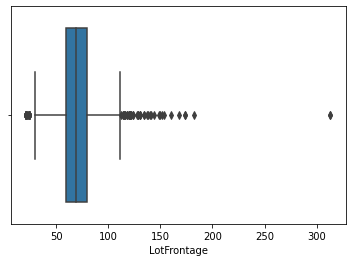

In [15]:
sns.boxplot(train["LotFrontage"]);

There is no pattern between "SalePrice" and "LotFrontage". And also we can see there might be outlier data in "LotFrontage". So we must fill these "NaN" with median.

In [16]:
data.groupby("HouseStyle")["LotFrontage"].median()

HouseStyle
1.5Fin   60.00
1.5Unf   55.00
1Story   70.00
2.5Fin   83.00
2.5Unf   60.00
2Story   69.00
SFoyer   68.50
SLvl     76.00
Name: LotFrontage, dtype: float64

In [17]:
train["LotFrontage"] = train["LotFrontage"].fillna(train.groupby("HouseStyle")["LotFrontage"].transform("median"))
data["LotFrontage"] = data["LotFrontage"].fillna(data.groupby("HouseStyle")["LotFrontage"].transform("median"))

In [18]:
train["MasVnrType"] = train["MasVnrType"].fillna("None")
data["MasVnrType"] = data["MasVnrType"].fillna("None")

In [19]:
train["MasVnrArea"] = train["MasVnrArea"].fillna(0)
data["MasVnrArea"] = data["MasVnrArea"].fillna(0)

In the description, we were given that "NaN" means "No Basement" in basement columns.

In [20]:
data[["BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF","BsmtFullBath", "BsmtHalfBath", "GarageCars", "GarageArea", "GarageYrBlt"]] = data[["BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF","BsmtFullBath", "BsmtHalfBath", "GarageCars", "GarageArea", "GarageYrBlt"]].fillna(0)
train[["BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF","BsmtFullBath", "BsmtHalfBath", "GarageCars", "GarageArea", "GarageYrBlt"]] = train[["BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF","BsmtFullBath", "BsmtHalfBath", "GarageCars", "GarageArea", "GarageYrBlt"]].fillna(0)

In [21]:
train[["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "FireplaceQu", "GarageType", "GarageFinish", "GarageQual", "GarageCond"]] = train[["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "FireplaceQu", "GarageType", "GarageFinish", "GarageQual", "GarageCond"]].fillna("No")
data[["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "FireplaceQu", "GarageType", "GarageFinish", "GarageQual", "GarageCond"]] = data[["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "FireplaceQu", "GarageType", "GarageFinish", "GarageQual", "GarageCond"]].fillna("No")

In [22]:
data["Electrical"].value_counts()

SBrkr    2671
FuseA     188
FuseF      50
FuseP       8
Mix         1
Name: Electrical, dtype: int64

In [23]:
train["Electrical"] = train["Electrical"].fillna("SBrkr")
data["Electrical"] = data["Electrical"].fillna("SBrkr")

In [24]:
train.isnull().sum().any()

False

In [25]:
data["Utilities"].value_counts()

AllPub    2916
NoSeWa       1
Name: Utilities, dtype: int64

In [26]:
mode_list = ["Utilities", "KitchenQual", "Functional", "MSZoning", "SaleType"]

for m in mode_list:
    data[m] = data[m].fillna(data[m].mode()[0])

In [27]:
data[["Exterior1st", "Exterior2nd"]] = data[["Exterior1st", "Exterior2nd"]].fillna("Other")

In [28]:
data.isnull().sum().any()

False

# **Outlier Detection**

In [29]:
data_num = data[num_cols]
data_num.head()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,SalePrice
0,65.00,8450,2003,2003,196.00,706.00,0.00,150.00,856.00,856,854,0,1710,2003.00,548.00,0,61,0,0,0,0,208500.00
1,80.00,9600,1976,1976,0.00,978.00,0.00,284.00,1262.00,1262,0,0,1262,1976.00,460.00,298,0,0,0,0,0,181500.00
2,68.00,11250,2001,2002,162.00,486.00,0.00,434.00,920.00,920,866,0,1786,2001.00,608.00,0,42,0,0,0,0,223500.00
3,60.00,9550,1915,1970,0.00,216.00,0.00,540.00,756.00,961,756,0,1717,1998.00,642.00,0,35,272,0,0,0,140000.00
4,84.00,14260,2000,2000,350.00,655.00,0.00,490.00,1145.00,1145,1053,0,2198,2000.00,836.00,192,84,0,0,0,0,250000.00


In [30]:
lof = LocalOutlierFactor(contamination = 0.1)
lof.fit_predict(data_num)
data_scores = lof.negative_outlier_factor_

In [31]:
np.sort(data_scores)[0:50]

array([-8.14580209, -7.54104296, -7.52838316, -6.06479009, -5.90006499,
       -5.37758211, -5.15001428, -4.31647145, -4.13033811, -4.00713311,
       -4.00043321, -3.89894046, -3.85853416, -3.68321591, -3.68192069,
       -3.60016846, -3.52827949, -3.47832738, -3.2588893 , -3.20179517,
       -3.18569059, -3.17099839, -3.13548997, -3.04941398, -2.99278952,
       -2.97887779, -2.96905384, -2.93156417, -2.89463549, -2.78884364,
       -2.78816756, -2.77171661, -2.76084593, -2.68857227, -2.63698378,
       -2.61243534, -2.60820021, -2.58670103, -2.57226032, -2.54304343,
       -2.52136983, -2.50953934, -2.49772838, -2.48827093, -2.45481155,
       -2.45428093, -2.4373724 , -2.42338444, -2.41847874, -2.38803281])

In [32]:
threshold = np.sort(data_scores)[11]
threshold

-3.8989404637062455

In [33]:
new_data = data_num[data_scores >= threshold]

In [34]:
new_data.head()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,SalePrice
0,65.00,8450,2003,2003,196.00,706.00,0.00,150.00,856.00,856,854,0,1710,2003.00,548.00,0,61,0,0,0,0,208500.00
1,80.00,9600,1976,1976,0.00,978.00,0.00,284.00,1262.00,1262,0,0,1262,1976.00,460.00,298,0,0,0,0,0,181500.00
2,68.00,11250,2001,2002,162.00,486.00,0.00,434.00,920.00,920,866,0,1786,2001.00,608.00,0,42,0,0,0,0,223500.00
3,60.00,9550,1915,1970,0.00,216.00,0.00,540.00,756.00,961,756,0,1717,1998.00,642.00,0,35,272,0,0,0,140000.00
4,84.00,14260,2000,2000,350.00,655.00,0.00,490.00,1145.00,1145,1053,0,2198,2000.00,836.00,192,84,0,0,0,0,250000.00


In [35]:
data_num.shape

(2919, 22)

In [36]:
new_data.shape

(2908, 22)

We had 2919 data but after cleaning outliers we have 2908 data now. 11 outlier data has been detected.

But we don't want to delete these data. We want to replace them with threshold data.

In [37]:
threshold_data = data[data_scores == threshold]
threshold_data

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
384,60,RL,69.00,53107,Pave,IR2,Low,AllPub,Corner,Mod,ClearCr,Feedr,Norm,1Fam,2Story,6,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.00,Gd,TA,PConc,Gd,TA,Av,GLQ,985.00,Unf,0.00,595.00,1580.00,GasA,Ex,Y,SBrkr,1079,874,0,1953,1.00,0.00,2,1,3,1,Gd,9,Typ,2,Fa,Attchd,1992.00,Fin,2.00,501.00,TA,TA,Y,216,231,0,0,0,0,0,6,2007,WD,Normal,240000.00


In [38]:
data[data_scores < threshold]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
249,50,RL,60.00,159000,Pave,IR2,Low,AllPub,CulDSac,Sev,ClearCr,Norm,Norm,1Fam,1.5Fin,6,7,1958,2006,Gable,CompShg,Wd Sdng,HdBoard,BrkCmn,472.00,Gd,TA,CBlock,Gd,TA,Gd,Rec,697.00,Unf,0.00,747.00,1444.00,GasA,Gd,Y,SBrkr,1444,700,0,2144,0.00,1.00,2,0,4,1,Gd,7,Typ,2,TA,Attchd,1958.00,Fin,2.00,389.00,TA,TA,Y,0,98,0,0,0,0,500,6,2007,WD,Normal,277000.00
313,20,RL,150.00,215245,Pave,IR3,Low,AllPub,Inside,Sev,Timber,Norm,Norm,1Fam,1Story,7,5,1965,1965,Hip,CompShg,BrkFace,BrkFace,None,0.00,TA,TA,CBlock,Gd,TA,Gd,ALQ,1236.00,Rec,820.00,80.00,2136.00,GasW,TA,Y,SBrkr,2036,0,0,2036,2.00,0.00,2,0,3,1,TA,8,Typ,2,Gd,Attchd,1965.00,RFn,2.00,513.00,TA,TA,Y,0,0,0,0,0,0,0,6,2009,WD,Normal,375000.00
335,190,RL,60.00,164660,Grvl,IR1,HLS,AllPub,Corner,Sev,Timber,Norm,Norm,2fmCon,1.5Fin,5,6,1965,1965,Gable,CompShg,Plywood,Plywood,None,0.00,TA,TA,CBlock,TA,TA,Gd,ALQ,1249.00,BLQ,147.00,103.00,1499.00,GasA,Ex,Y,SBrkr,1619,167,0,1786,2.00,0.00,2,0,3,1,TA,7,Typ,2,Gd,Attchd,1965.00,Fin,2.00,529.00,TA,TA,Y,670,0,0,0,0,0,700,8,2008,WD,Normal,228950.00
346,20,RL,70.00,12772,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,8,1960,1998,Hip,CompShg,MetalSd,MetalSd,None,0.00,TA,Gd,CBlock,TA,TA,Mn,BLQ,498.00,Unf,0.00,460.00,958.00,GasA,TA,Y,SBrkr,958,0,0,958,0.00,0.00,1,0,2,1,TA,5,Typ,0,No,Attchd,1960.00,RFn,1.00,301.00,TA,TA,Y,0,0,0,0,0,0,15500,4,2007,WD,Normal,151500.00
451,20,RL,62.00,70761,Pave,IR1,Low,AllPub,Inside,Mod,ClearCr,Norm,Norm,1Fam,1Story,7,5,1975,1975,Gable,WdShngl,Plywood,Plywood,None,0.00,TA,TA,CBlock,Gd,TA,Gd,ALQ,655.00,Unf,0.00,878.00,1533.00,GasA,TA,Y,SBrkr,1533,0,0,1533,1.00,0.00,2,0,2,1,Gd,5,Typ,2,TA,Attchd,1975.00,Unf,2.00,576.00,TA,TA,Y,200,54,0,0,0,0,0,12,2006,WD,Normal,280000.00
691,60,RL,104.00,21535,Pave,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,6,1994,1995,Gable,WdShngl,HdBoard,HdBoard,BrkFace,1170.00,Ex,TA,PConc,Ex,TA,Gd,GLQ,1455.00,Unf,0.00,989.00,2444.00,GasA,Ex,Y,SBrkr,2444,1872,0,4316,0.00,1.00,3,1,4,1,Ex,10,Typ,2,Ex,Attchd,1994.00,Fin,3.00,832.00,TA,TA,Y,382,50,0,0,0,0,0,1,2007,WD,Normal,755000.00
706,20,RL,70.00,115149,Pave,IR2,Low,AllPub,CulDSac,Sev,ClearCr,Norm,Norm,1Fam,1Story,7,5,1971,2002,Gable,CompShg,Plywood,Plywood,Stone,351.00,TA,TA,CBlock,Gd,TA,Gd,GLQ,1219.00,Unf,0.00,424.00,1643.00,GasA,TA,Y,SBrkr,1824,0,0,1824,1.00,0.00,2,0,2,1,Gd,5,Typ,2,TA,Attchd,1971.00,Unf,2.00,739.00,TA,TA,Y,380,48,0,0,0,0,0,6,2007,WD,Normal,302000.00
1182,60,RL,160.00,15623,Pave,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,5,1996,1996,Hip,CompShg,Wd Sdng,ImStucc,None,0.00,Gd,TA,PConc,Ex,TA,Av,GLQ,2096.00,Unf,0.00,300.00,2396.00,GasA,Ex,Y,SBrkr,2411,2065,0,4476,1.00,0.00,3,1,4,1,Ex,10,Typ,2,TA,Attchd,1996.00,Fin,3.00,813.00,TA,TA,Y,171,78,0,0,0,555,0,7,2007,WD,Abnorml,745000.00
1298,60,RL,313.00,63887,Pave,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.00,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644.00,Unf,0.00,466.00,6110.00,GasA,Ex,Y,SBrkr,4692,950,0,5642,2.00,0.00,2,1,3,1,Ex,12,Typ,3,Gd,Attchd,2008.00,Fin,2.00,1418.00,TA,TA,Y,214,292,0,0,0,480,0,1,2008,New,Partial,160000.00
1461,20,RL,81.00,14267,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1St

In [39]:
# Some index operations must be performed to make the outliers equal to the threshold value.

ind = data[data_scores < threshold].to_records(index = False)

In [40]:
ind[:] = threshold_data.to_records(index = False)
ind

rec.array([(60, 'RL', 69., 53107, 'Pave', 'IR2', 'Low', 'AllPub', 'Corner', 'Mod', 'ClearCr', 'Feedr', 'Norm', '1Fam', '2Story', 6, 5, 1992, 1992, 'Gable', 'CompShg', 'HdBoard', 'HdBoard', 'None', 0., 'Gd', 'TA', 'PConc', 'Gd', 'TA', 'Av', 'GLQ', 985., 'Unf', 0., 595., 1580., 'GasA', 'Ex', 'Y', 'SBrkr', 1079, 874, 0, 1953, 1., 0., 2, 1, 3, 1, 'Gd', 9, 'Typ', 2, 'Fa', 'Attchd', 1992., 'Fin', 2., 501., 'TA', 'TA', 'Y', 216, 231, 0, 0, 0, 0, 0, 6, 2007, 'WD', 'Normal', 240000.),
           (60, 'RL', 69., 53107, 'Pave', 'IR2', 'Low', 'AllPub', 'Corner', 'Mod', 'ClearCr', 'Feedr', 'Norm', '1Fam', '2Story', 6, 5, 1992, 1992, 'Gable', 'CompShg', 'HdBoard', 'HdBoard', 'None', 0., 'Gd', 'TA', 'PConc', 'Gd', 'TA', 'Av', 'GLQ', 985., 'Unf', 0., 595., 1580., 'GasA', 'Ex', 'Y', 'SBrkr', 1079, 874, 0, 1953, 1., 0., 2, 1, 3, 1, 'Gd', 9, 'Typ', 2, 'Fa', 'Attchd', 1992., 'Fin', 2., 501., 'TA', 'TA', 'Y', 216, 231, 0, 0, 0, 0, 0, 6, 2007, 'WD', 'Normal', 240000.),
           (60, 'RL', 69., 53107, 'Pav

In [41]:
data[data_scores < threshold] = pd.DataFrame(ind, index = data[data_scores < threshold].index)

In [42]:
data[data_scores < threshold]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
249,60,RL,69.00,53107,Pave,IR2,Low,AllPub,Corner,Mod,ClearCr,Feedr,Norm,1Fam,2Story,6,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.00,Gd,TA,PConc,Gd,TA,Av,GLQ,985.00,Unf,0.00,595.00,1580.00,GasA,Ex,Y,SBrkr,1079,874,0,1953,1.00,0.00,2,1,3,1,Gd,9,Typ,2,Fa,Attchd,1992.00,Fin,2.00,501.00,TA,TA,Y,216,231,0,0,0,0,0,6,2007,WD,Normal,240000.00
313,60,RL,69.00,53107,Pave,IR2,Low,AllPub,Corner,Mod,ClearCr,Feedr,Norm,1Fam,2Story,6,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.00,Gd,TA,PConc,Gd,TA,Av,GLQ,985.00,Unf,0.00,595.00,1580.00,GasA,Ex,Y,SBrkr,1079,874,0,1953,1.00,0.00,2,1,3,1,Gd,9,Typ,2,Fa,Attchd,1992.00,Fin,2.00,501.00,TA,TA,Y,216,231,0,0,0,0,0,6,2007,WD,Normal,240000.00
335,60,RL,69.00,53107,Pave,IR2,Low,AllPub,Corner,Mod,ClearCr,Feedr,Norm,1Fam,2Story,6,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.00,Gd,TA,PConc,Gd,TA,Av,GLQ,985.00,Unf,0.00,595.00,1580.00,GasA,Ex,Y,SBrkr,1079,874,0,1953,1.00,0.00,2,1,3,1,Gd,9,Typ,2,Fa,Attchd,1992.00,Fin,2.00,501.00,TA,TA,Y,216,231,0,0,0,0,0,6,2007,WD,Normal,240000.00
346,60,RL,69.00,53107,Pave,IR2,Low,AllPub,Corner,Mod,ClearCr,Feedr,Norm,1Fam,2Story,6,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.00,Gd,TA,PConc,Gd,TA,Av,GLQ,985.00,Unf,0.00,595.00,1580.00,GasA,Ex,Y,SBrkr,1079,874,0,1953,1.00,0.00,2,1,3,1,Gd,9,Typ,2,Fa,Attchd,1992.00,Fin,2.00,501.00,TA,TA,Y,216,231,0,0,0,0,0,6,2007,WD,Normal,240000.00
451,60,RL,69.00,53107,Pave,IR2,Low,AllPub,Corner,Mod,ClearCr,Feedr,Norm,1Fam,2Story,6,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.00,Gd,TA,PConc,Gd,TA,Av,GLQ,985.00,Unf,0.00,595.00,1580.00,GasA,Ex,Y,SBrkr,1079,874,0,1953,1.00,0.00,2,1,3,1,Gd,9,Typ,2,Fa,Attchd,1992.00,Fin,2.00,501.00,TA,TA,Y,216,231,0,0,0,0,0,6,2007,WD,Normal,240000.00
691,60,RL,69.00,53107,Pave,IR2,Low,AllPub,Corner,Mod,ClearCr,Feedr,Norm,1Fam,2Story,6,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.00,Gd,TA,PConc,Gd,TA,Av,GLQ,985.00,Unf,0.00,595.00,1580.00,GasA,Ex,Y,SBrkr,1079,874,0,1953,1.00,0.00,2,1,3,1,Gd,9,Typ,2,Fa,Attchd,1992.00,Fin,2.00,501.00,TA,TA,Y,216,231,0,0,0,0,0,6,2007,WD,Normal,240000.00
706,60,RL,69.00,53107,Pave,IR2,Low,AllPub,Corner,Mod,ClearCr,Feedr,Norm,1Fam,2Story,6,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.00,Gd,TA,PConc,Gd,TA,Av,GLQ,985.00,Unf,0.00,595.00,1580.00,GasA,Ex,Y,SBrkr,1079,874,0,1953,1.00,0.00,2,1,3,1,Gd,9,Typ,2,Fa,Attchd,1992.00,Fin,2.00,501.00,TA,TA,Y,216,231,0,0,0,0,0,6,2007,WD,Normal,240000.00
1182,60,RL,69.00,53107,Pave,IR2,Low,AllPub,Corner,Mod,ClearCr,Feedr,Norm,1Fam,2Story,6,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.00,Gd,TA,PConc,Gd,TA,Av,GLQ,985.00,Unf,0.00,595.00,1580.00,GasA,Ex,Y,SBrkr,1079,874,0,1953,1.00,0.00,2,1,3,1,Gd,9,Typ,2,Fa,Attchd,1992.00,Fin,2.00,501.00,TA,TA,Y,216,231,0,0,0,0,0,6,2007,WD,Normal,240000.00
1298,60,RL,69.00,53107,Pave,IR2,Low,AllPub,Corner,Mod,ClearCr,Feedr,Norm,1Fam,2Story,6,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.00,Gd,TA,PConc,Gd,TA,Av,GLQ,985.00,Unf,0.00,595.00,1580.00,GasA,Ex,Y,SBrkr,1079,874,0,1953,1.00,0.00,2,1,3,1,Gd,9,Typ,2,Fa,Attchd,1992.00,Fin,2.00,501.00,TA,TA,Y,216,231,0,0,0,0,0,6,2007,WD,Normal,240000.00
1461,60,RL,69.00,53107,Pave,IR2,Low,AllPub,Corner,Mod,ClearCr,Feedr,Norm,1Fam,2Story,6,5,1992,1992

**Outlier detection for train:**

We examine this train data separately because, in the correlation matrix, we want to see how the "SalePrice" column correlated with the other numeric cols. In the "test" set, we don't have a "SalePrice" value, so if we use the "data" set, this might mislead us.

In [43]:
train_num = train.select_dtypes(include = ["float64", "int64"])
train_num.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.00,8450,7,5,2003,2003,196.00,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.00,2,548,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.00,9600,6,8,1976,1976,0.00,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.00,2,460,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.00,11250,7,5,2001,2002,162.00,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.00,2,608,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.00,9550,7,5,1915,1970,0.00,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.00,3,642,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.00,14260,8,5,2000,2000,350.00,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.00,3,836,192,84,0,0,0,0,0,12,2008,250000


In [44]:
t_lof = LocalOutlierFactor(contamination = 0.1)
t_lof.fit_predict(train_num)
train_scores = t_lof.negative_outlier_factor_

In [45]:
np.sort(train_scores)[0:50]

array([-8.12883975, -7.53728961, -7.50906045, -6.05997087, -5.35977665,
       -5.05079475, -4.30287411, -4.13002284, -4.00684219, -3.87962437,
       -3.84432229, -3.6661346 , -3.64258163, -3.55267407, -3.24277775,
       -3.16730666, -2.96329648, -2.92620252, -2.91471556, -2.8551083 ,
       -2.77152004, -2.63679118, -2.59911551, -2.55129509, -2.51132385,
       -2.49928322, -2.46780387, -2.45843859, -2.44326545, -2.42319752,
       -2.40311179, -2.3670414 , -2.24779256, -2.20738678, -2.18652364,
       -2.18075825, -2.17650689, -2.16952619, -2.07486729, -2.06034537,
       -2.0532833 , -1.93736959, -1.88341869, -1.86980332, -1.86820084,
       -1.84518604, -1.81705175, -1.81389686, -1.77876343, -1.76225164])

In [46]:
t_threshold = np.sort(train_scores)[9]
t_threshold

-3.879624369574212

In [47]:
new_train = train_num[train_scores >= t_threshold]
new_train.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.00,8450,7,5,2003,2003,196.00,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.00,2,548,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.00,9600,6,8,1976,1976,0.00,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.00,2,460,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.00,11250,7,5,2001,2002,162.00,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.00,2,608,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.00,9550,7,5,1915,1970,0.00,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.00,3,642,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.00,14260,8,5,2000,2000,350.00,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.00,3,836,192,84,0,0,0,0,0,12,2008,250000


# **Visualization**

*After all the cleaning and preparations, we can see the story of the last dataset*

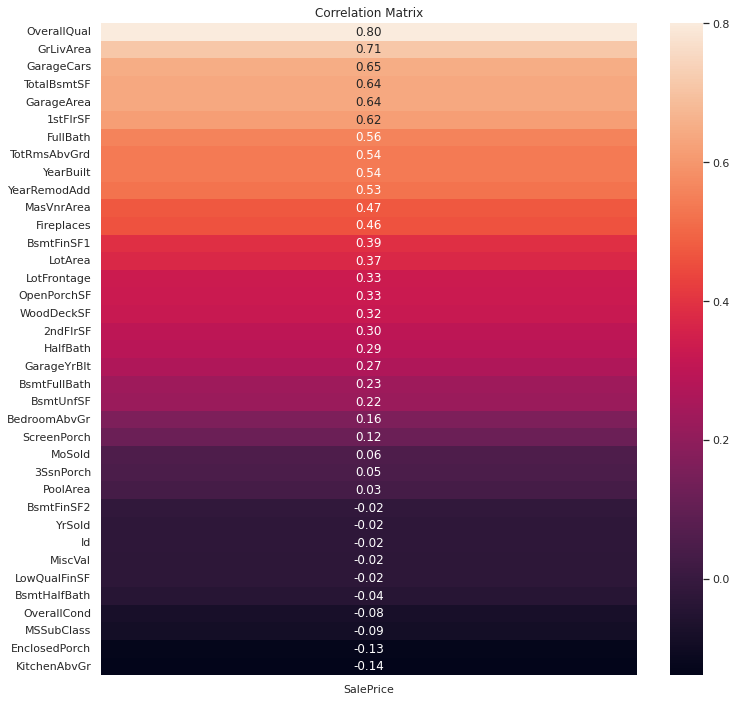

In [48]:
corr_matrix = new_train.corr()[['SalePrice']]
sns.set(rc={'figure.figsize': (12, 12)})
corr_matrix.drop(['SalePrice'], axis=0, inplace=True)
sns.heatmap(corr_matrix.sort_values(by='SalePrice', ascending=False), annot=True, fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

"SalePrice" correlated with, in positive order: "OverallQual" > "GrLivArea" > "GarageCars" > "TotalBsmtSF" = "GarageArea" > "1stFlrSF"

In [49]:
cat_cols, num_cols, cat_but_car, num_but_cat = categoric_data(data)

Observations: 2919
Variebles: 76
cat_cols: 54
num_cols: 22
cat_but_car: 0
num_but_cat: 15


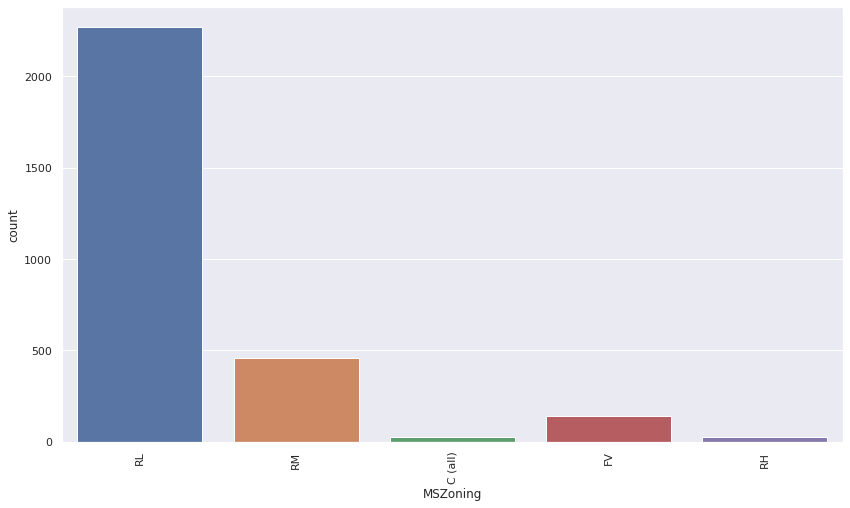

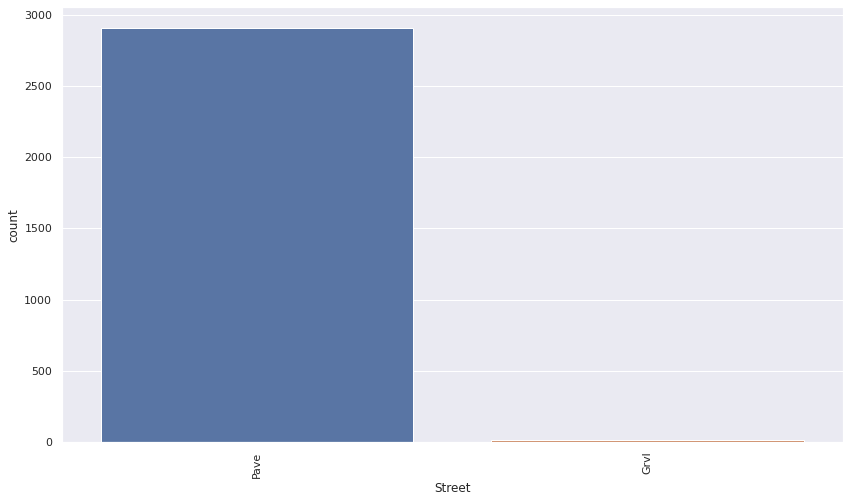

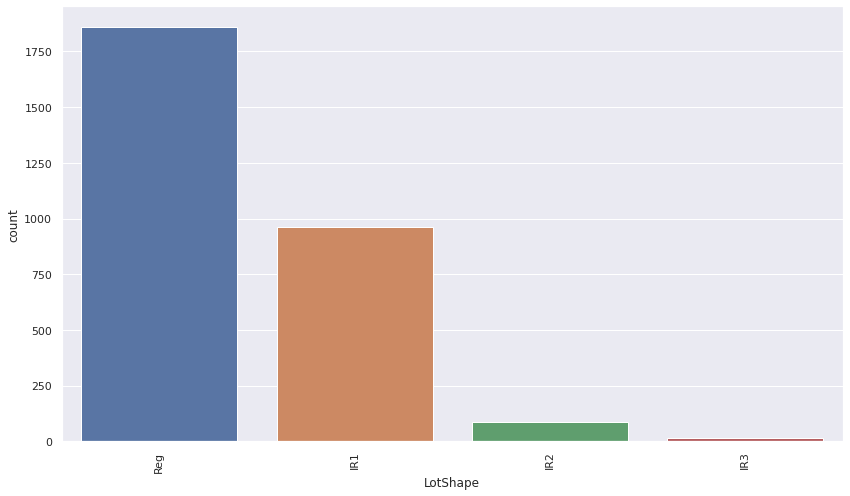

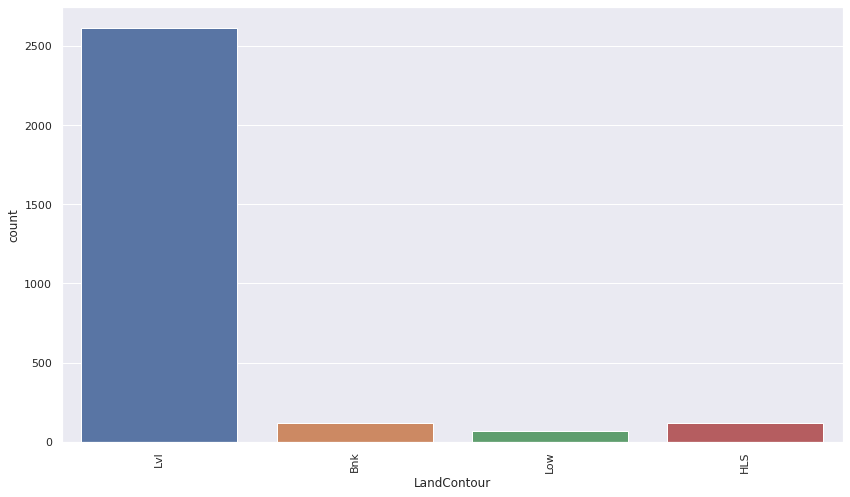

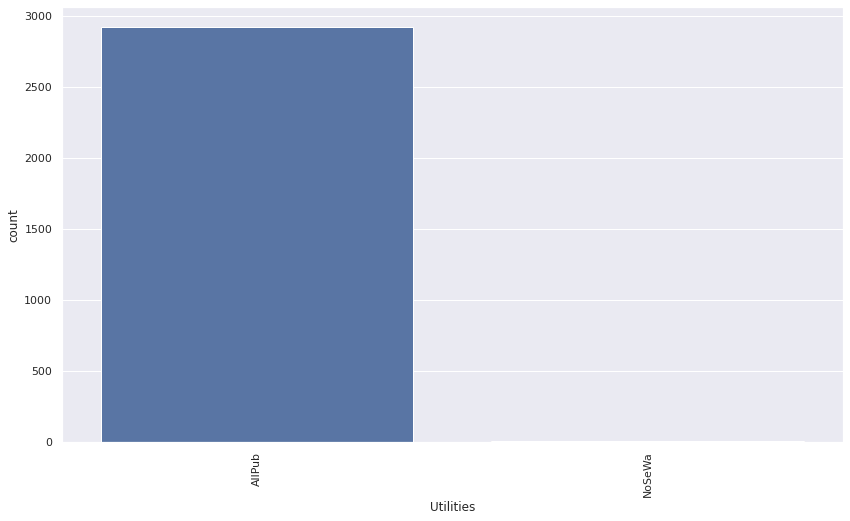

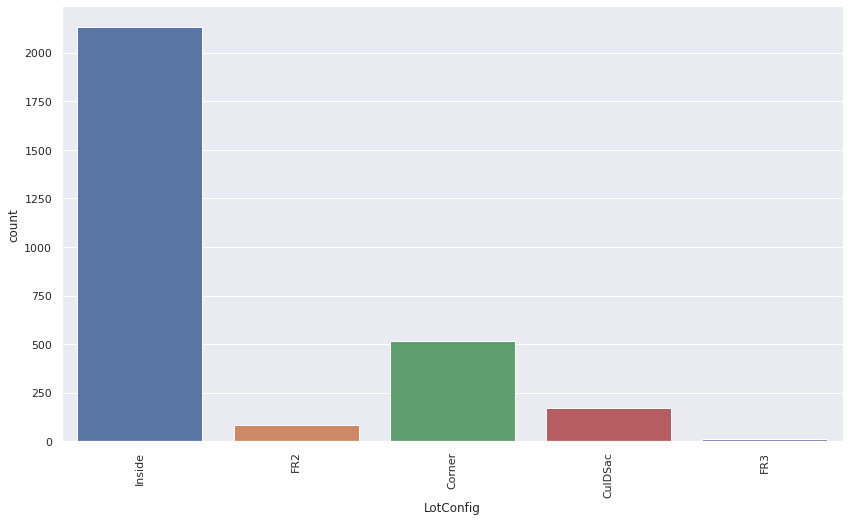

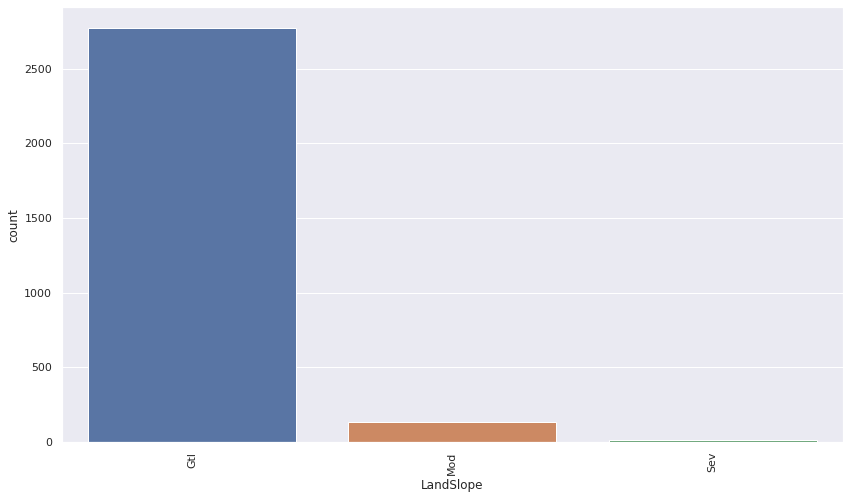

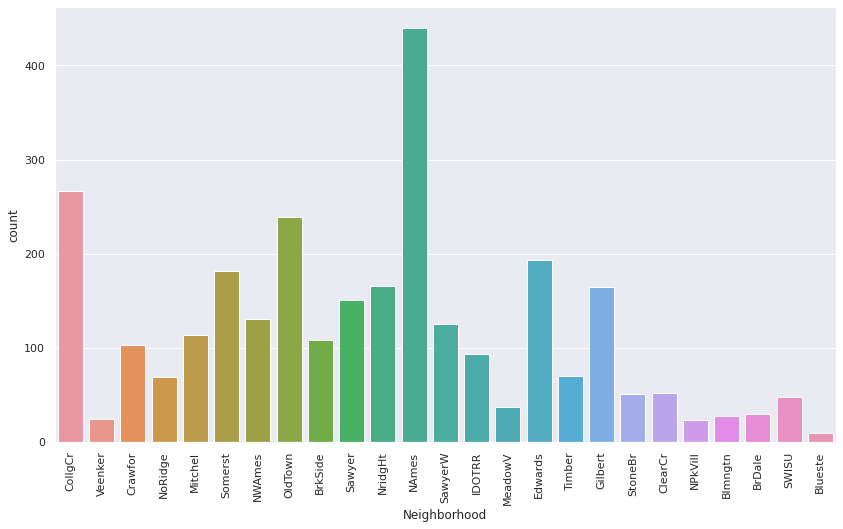

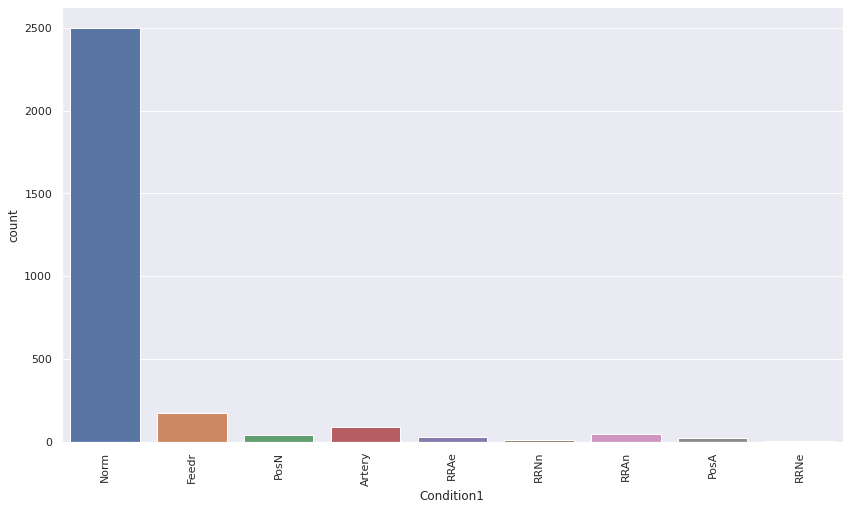

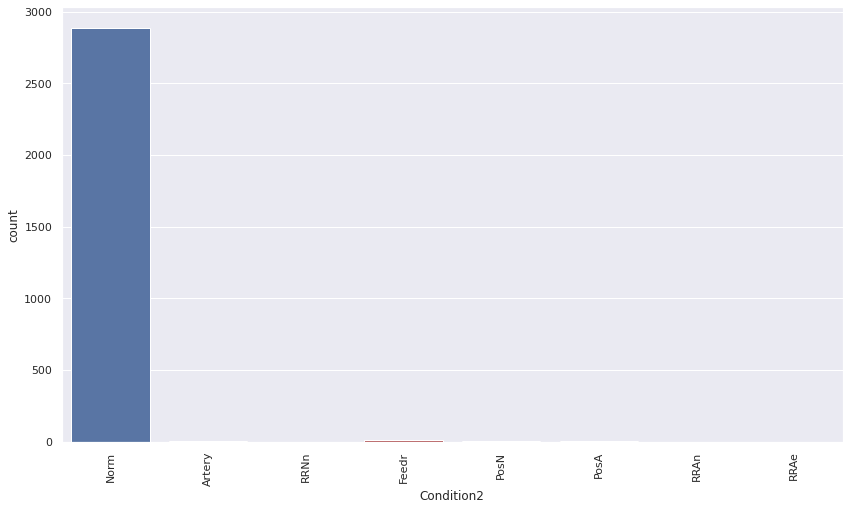

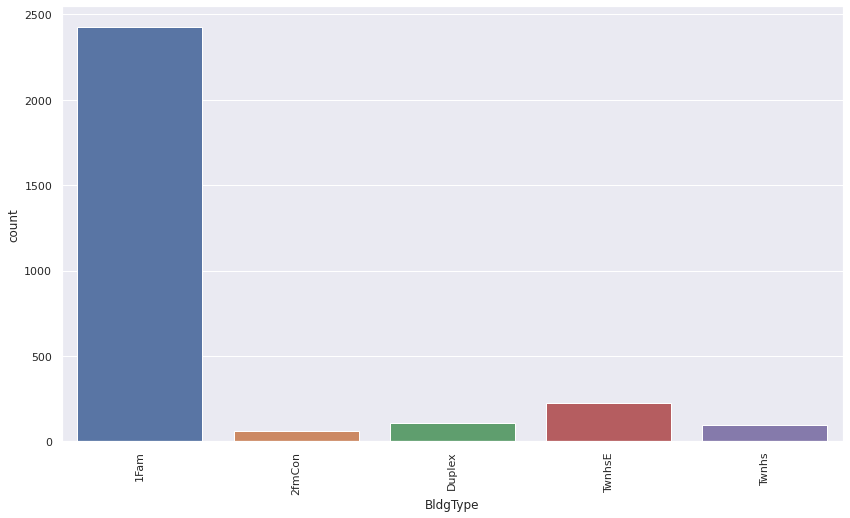

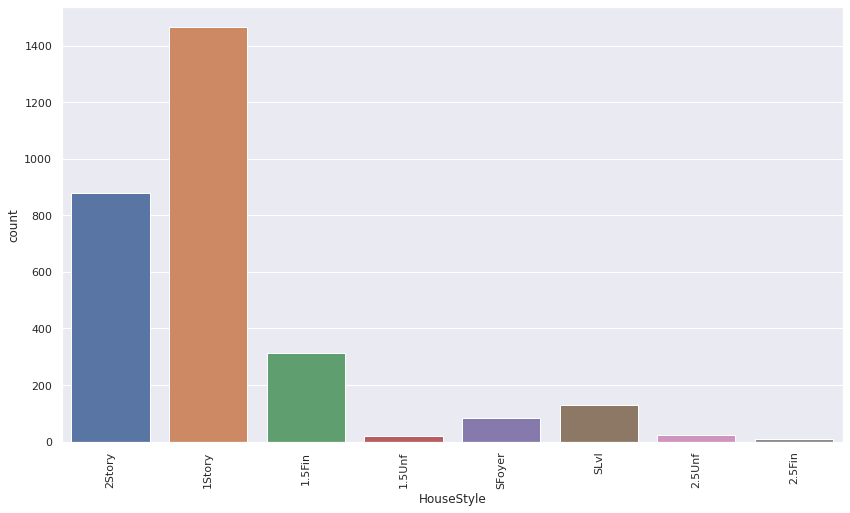

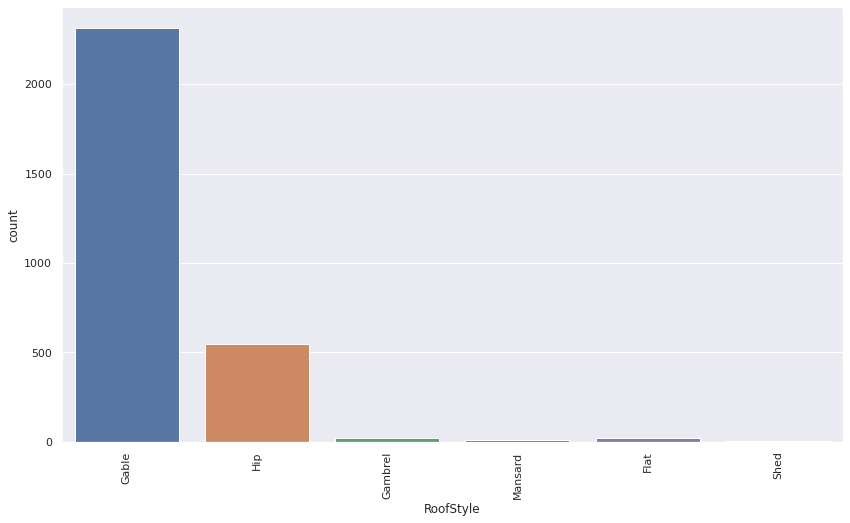

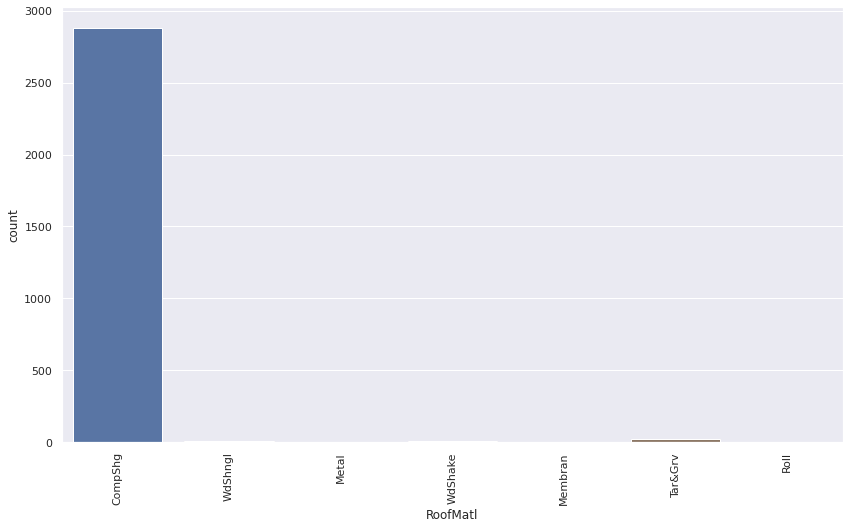

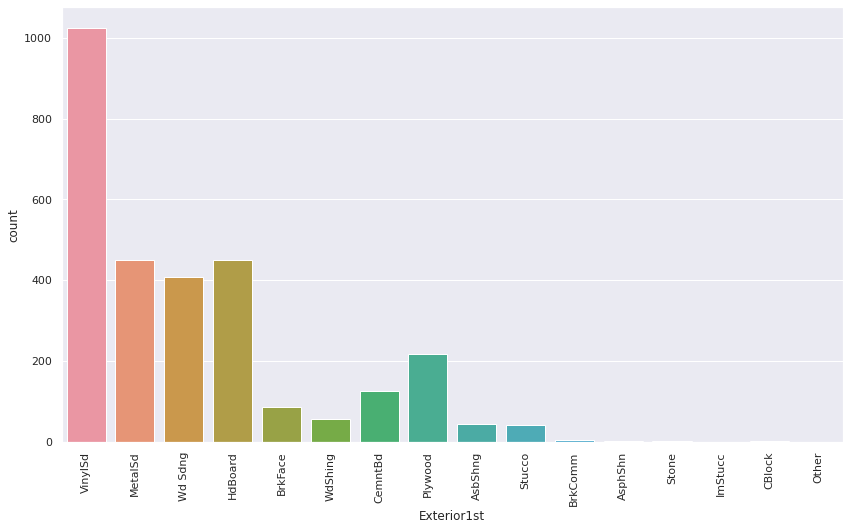

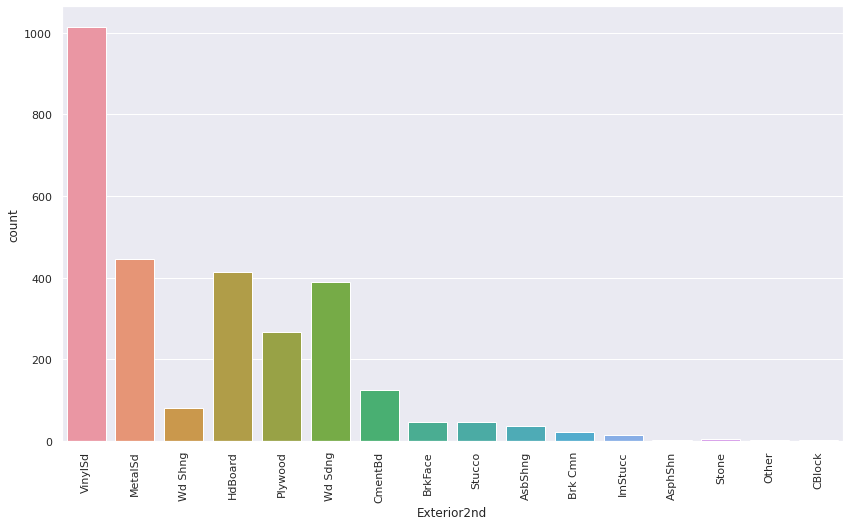

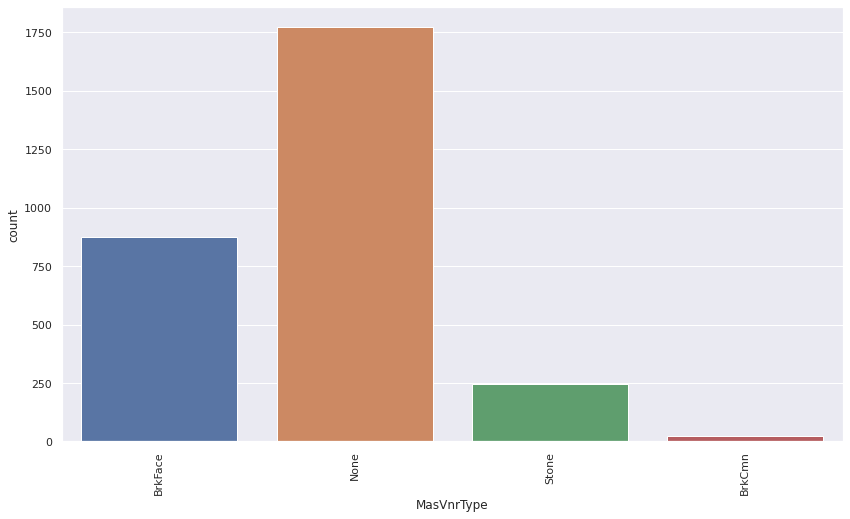

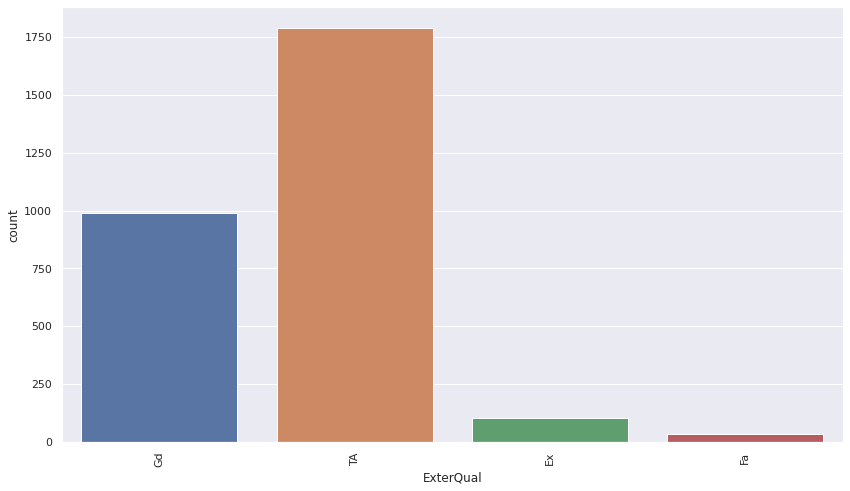

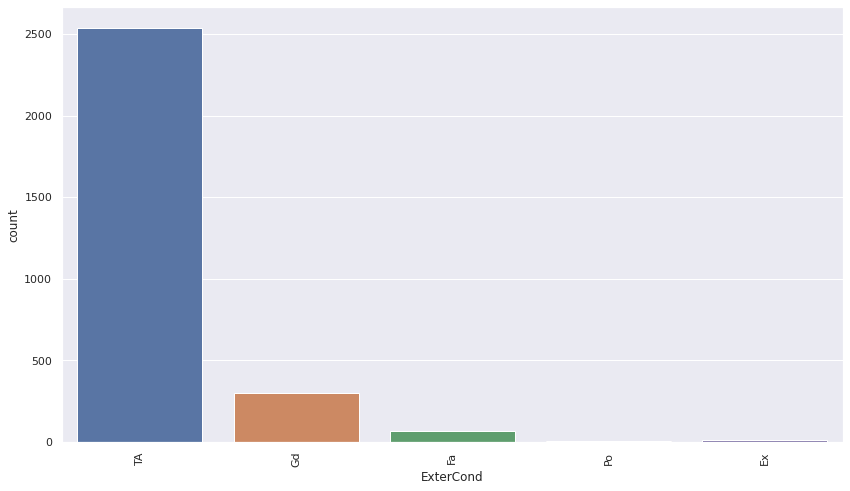

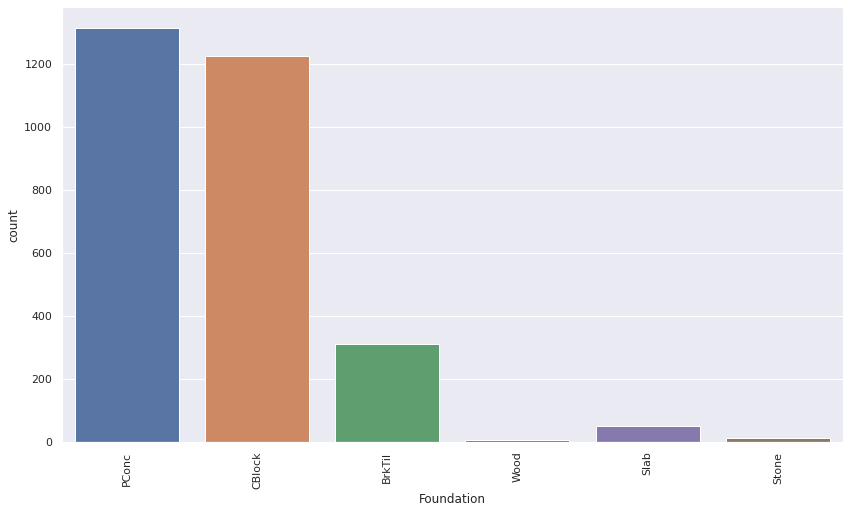

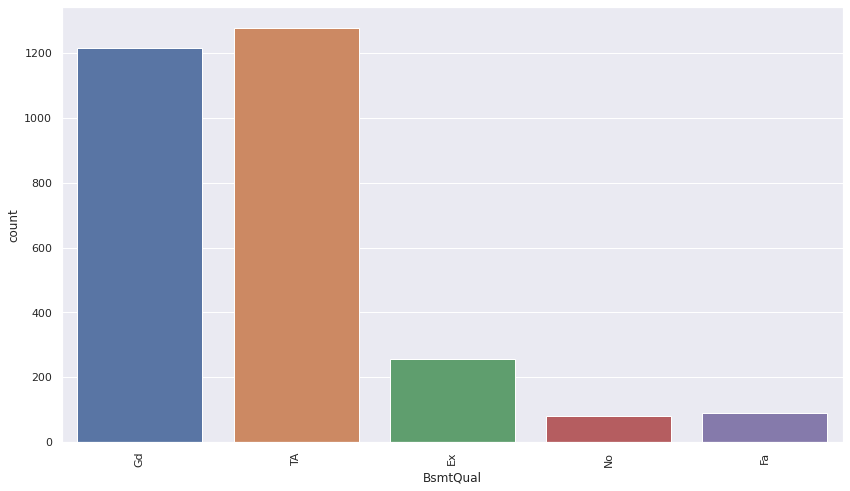

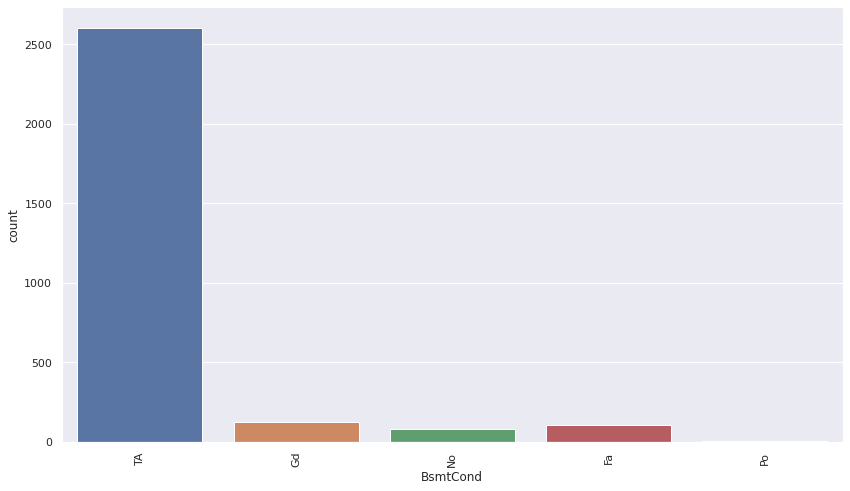

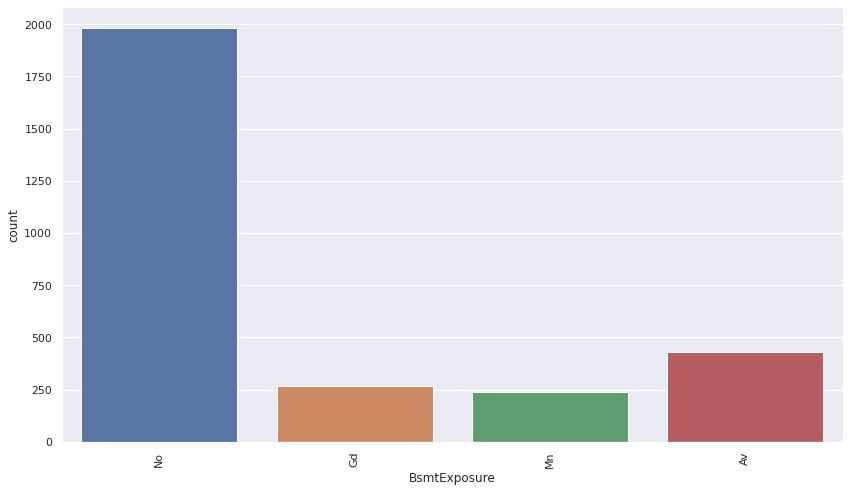

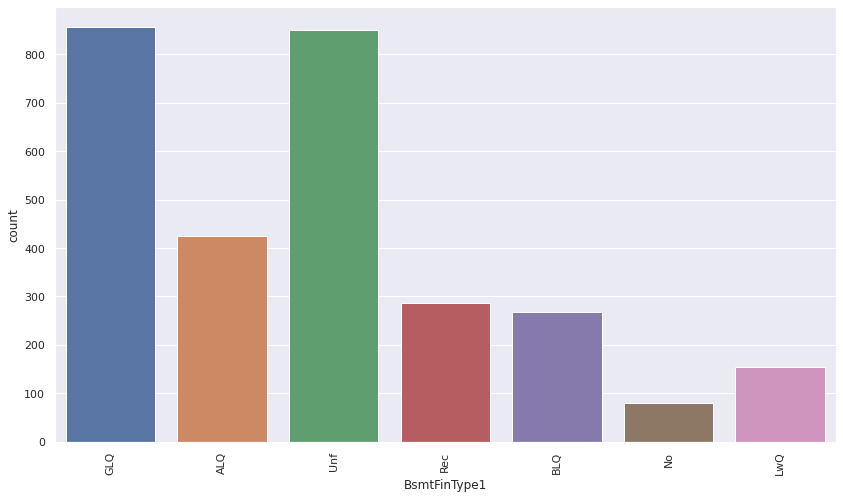

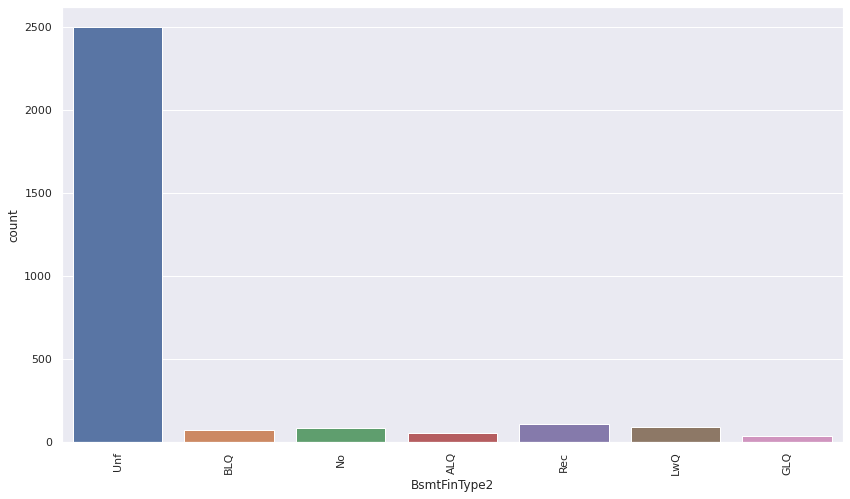

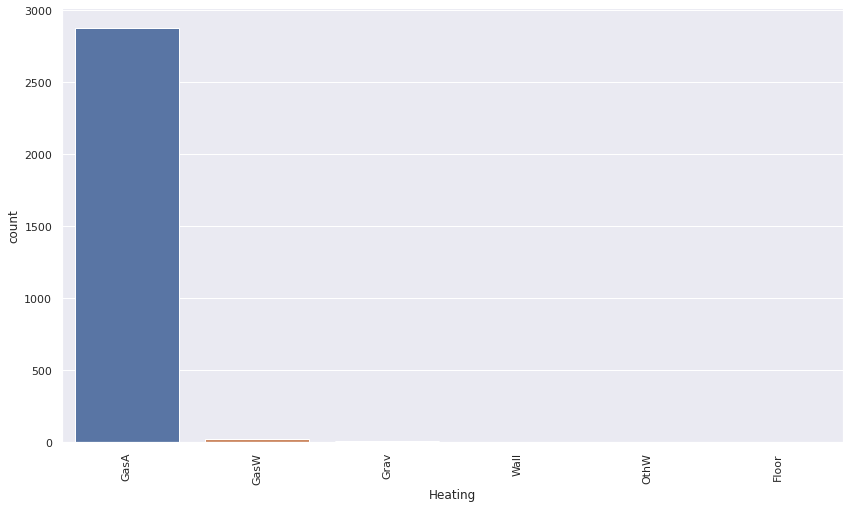

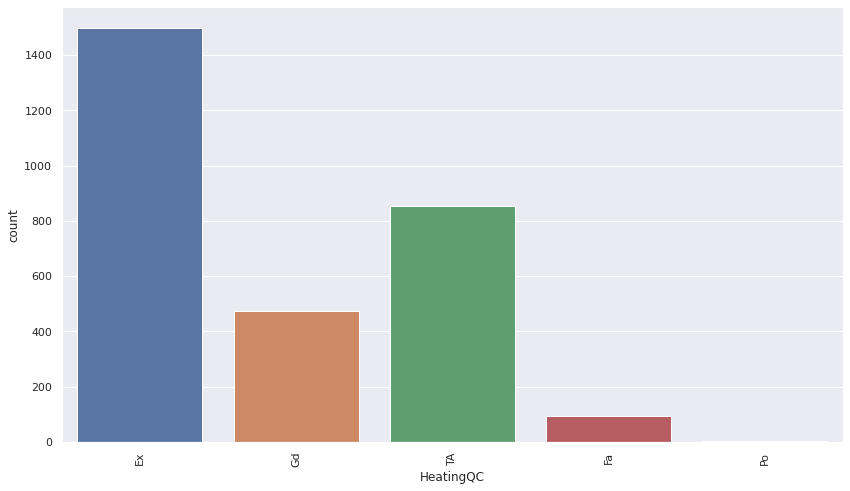

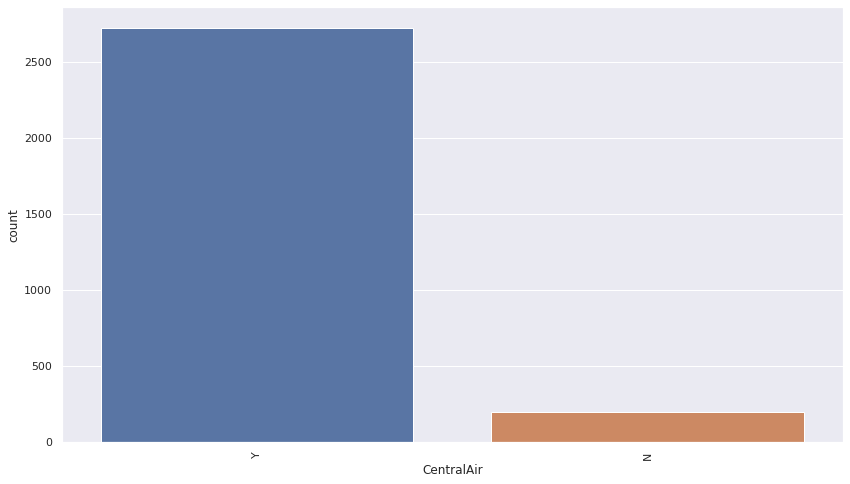

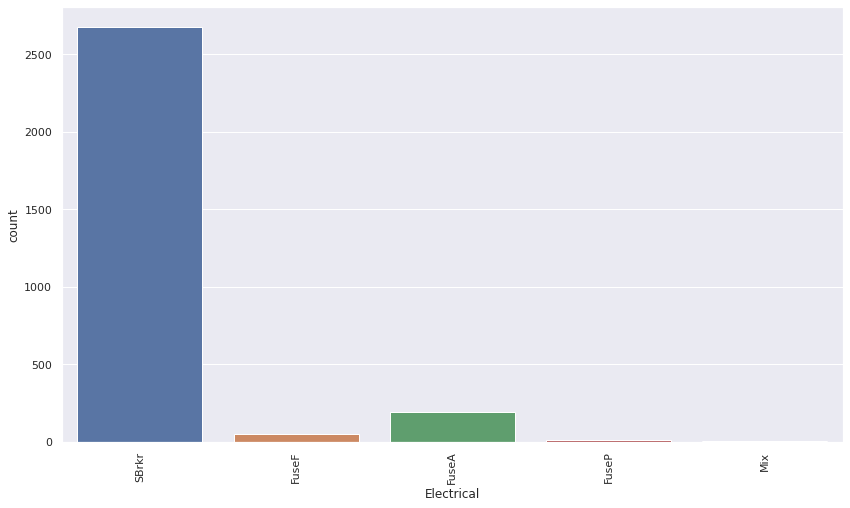

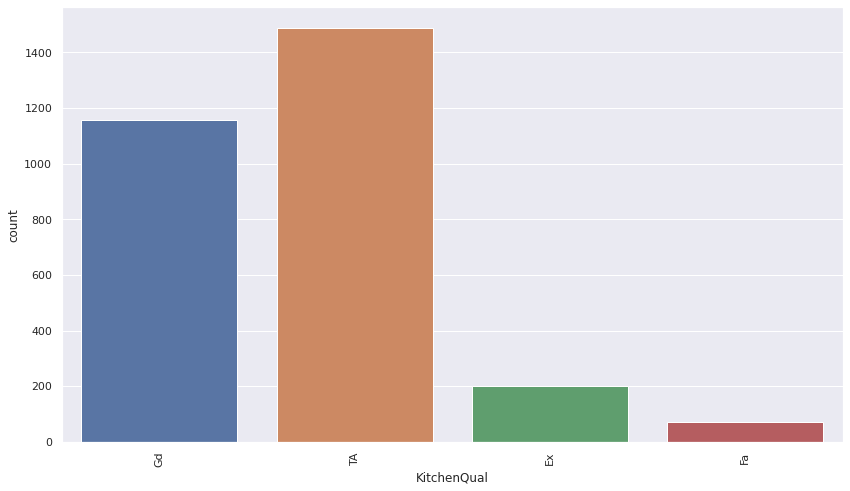

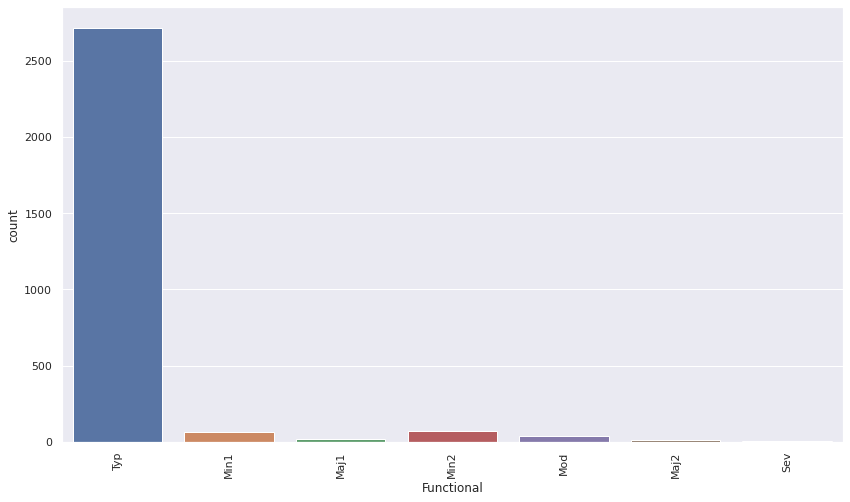

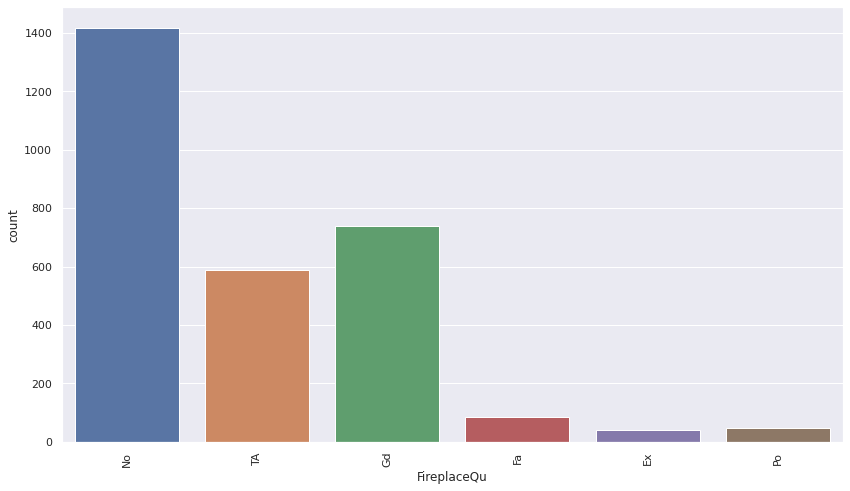

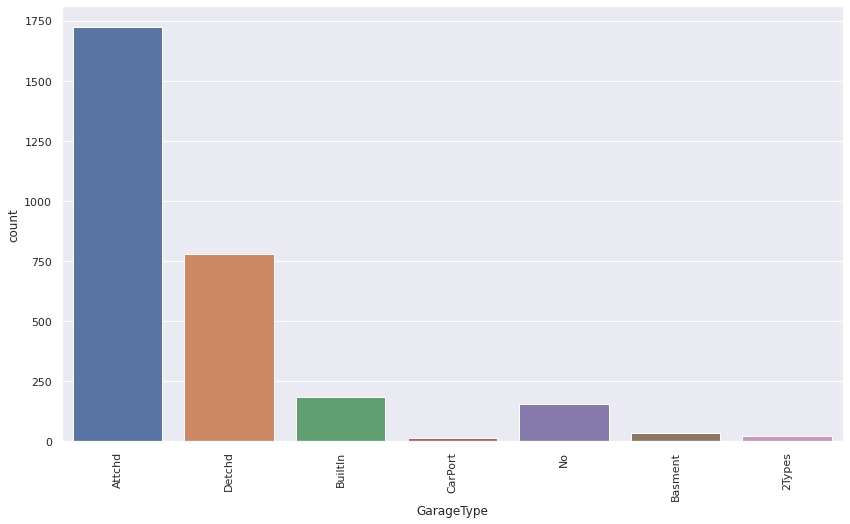

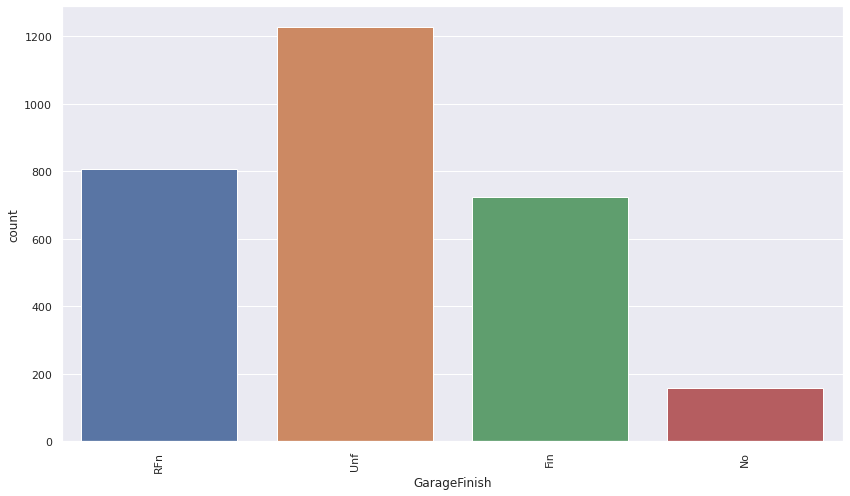

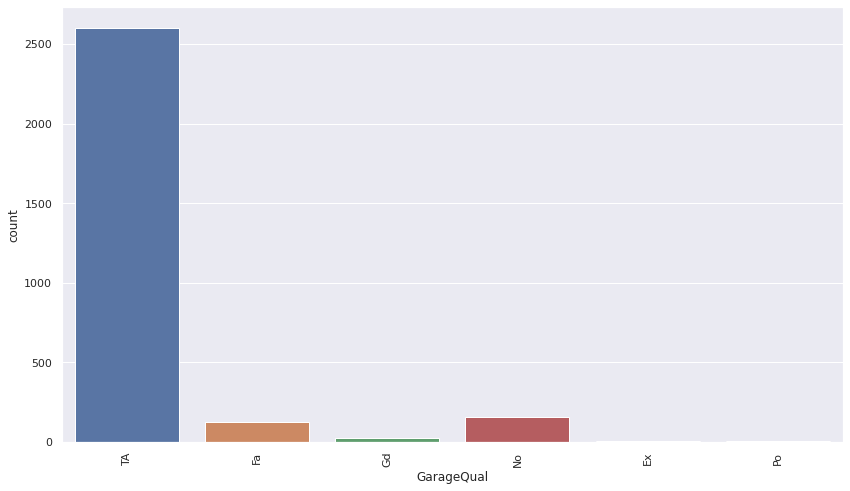

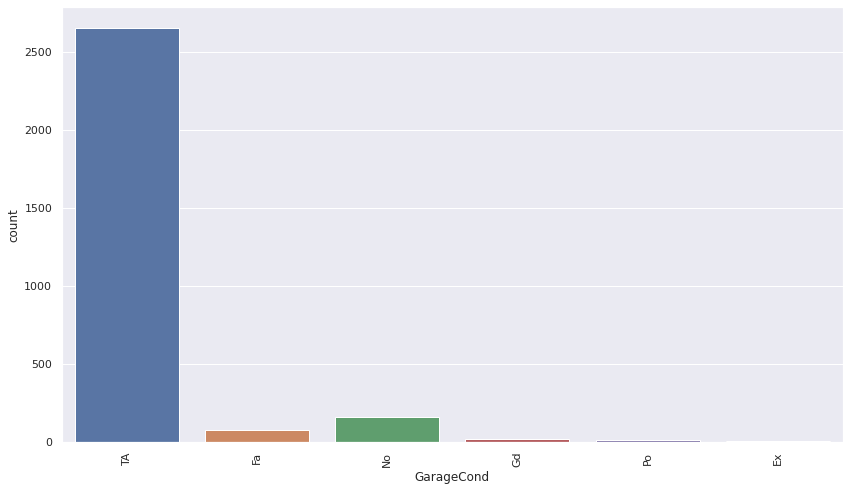

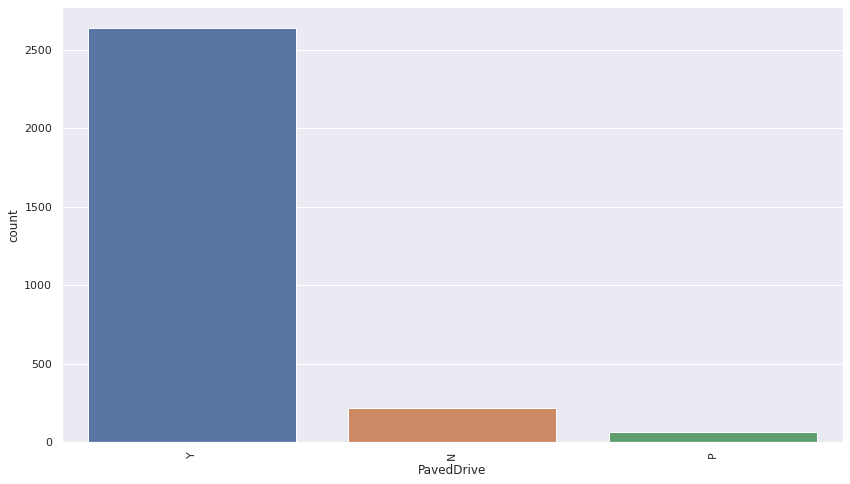

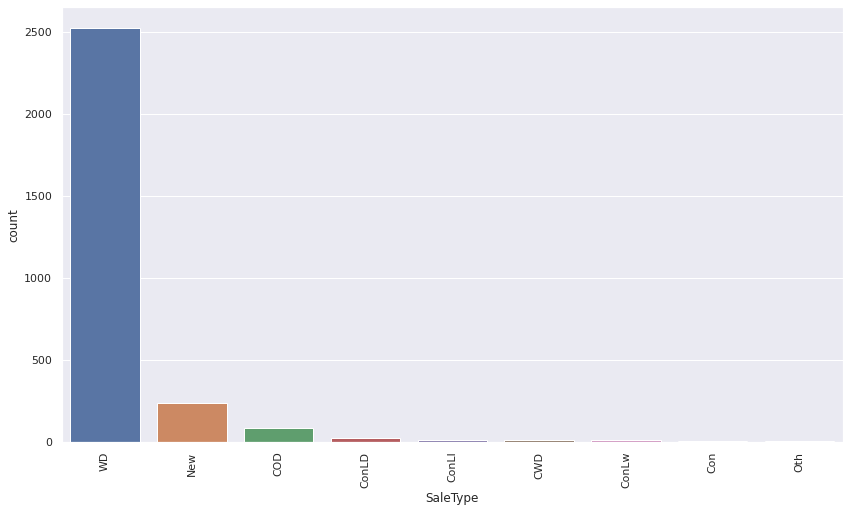

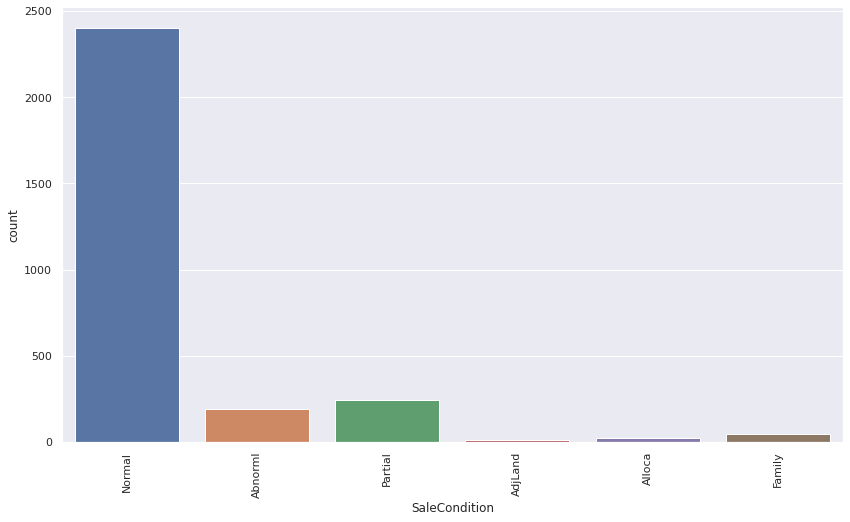

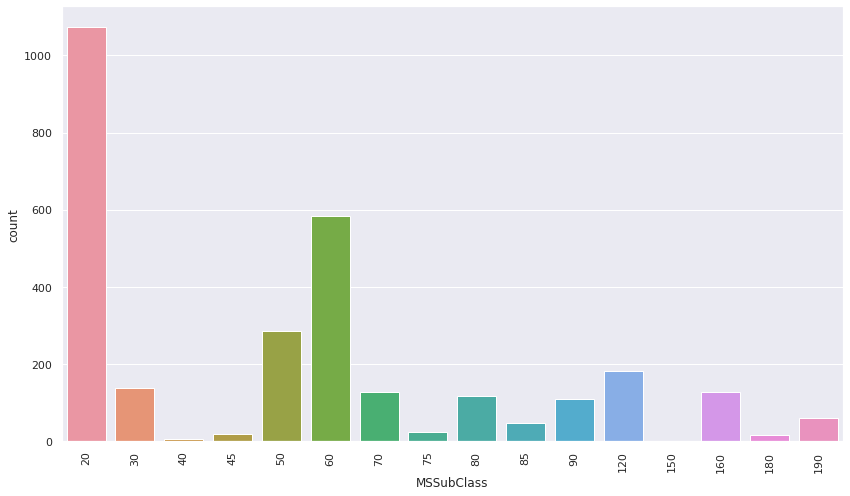

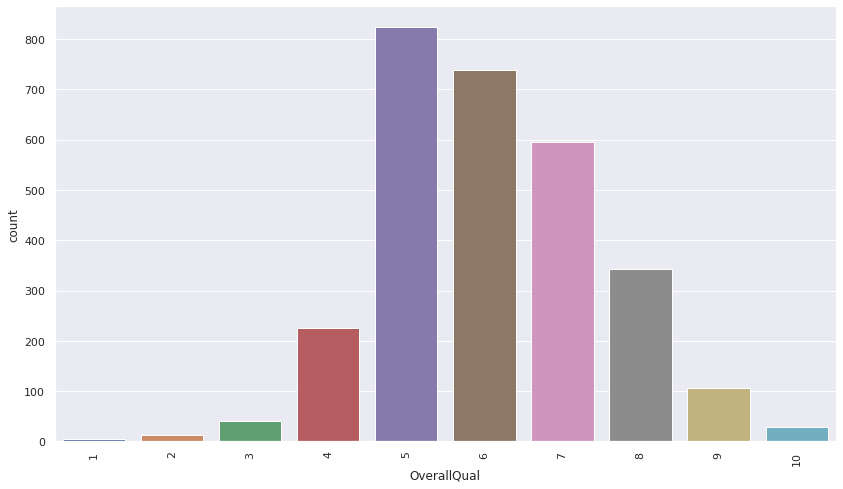

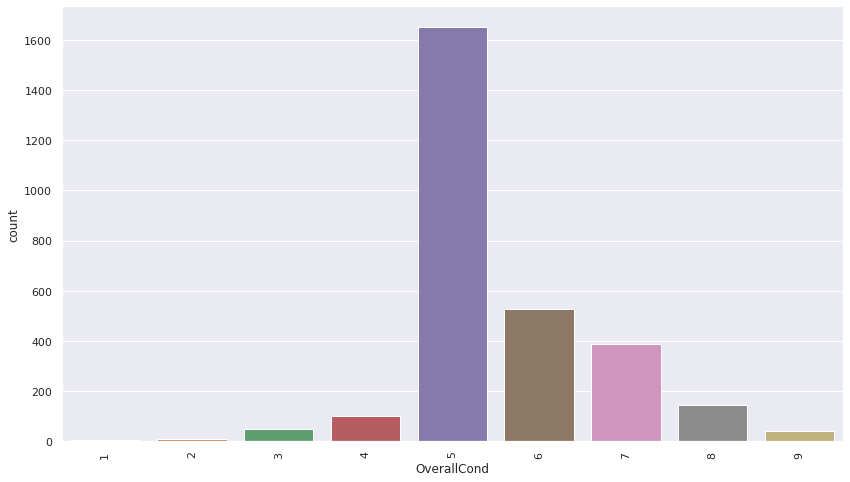

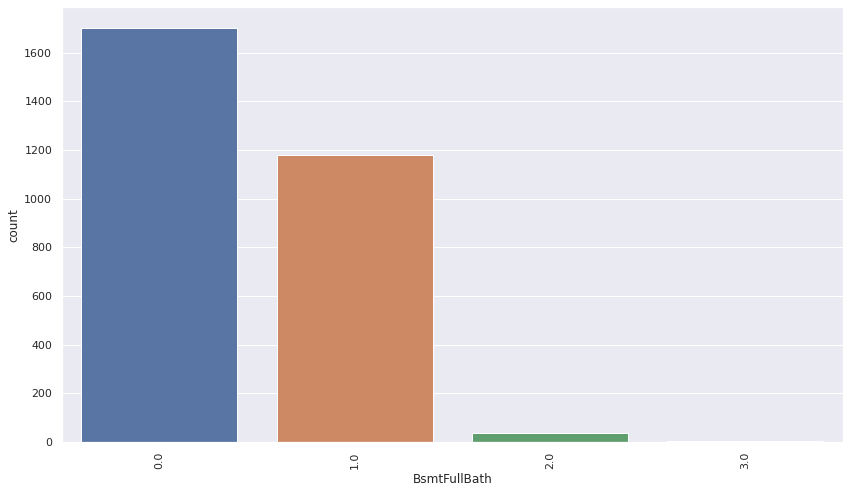

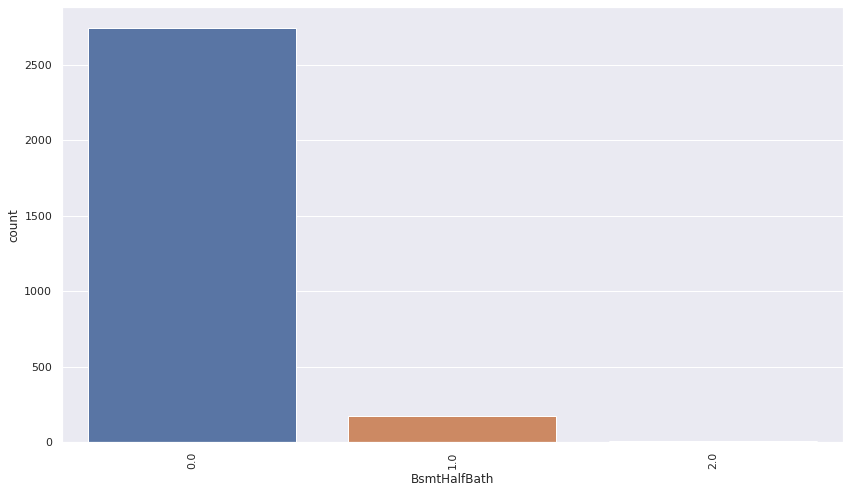

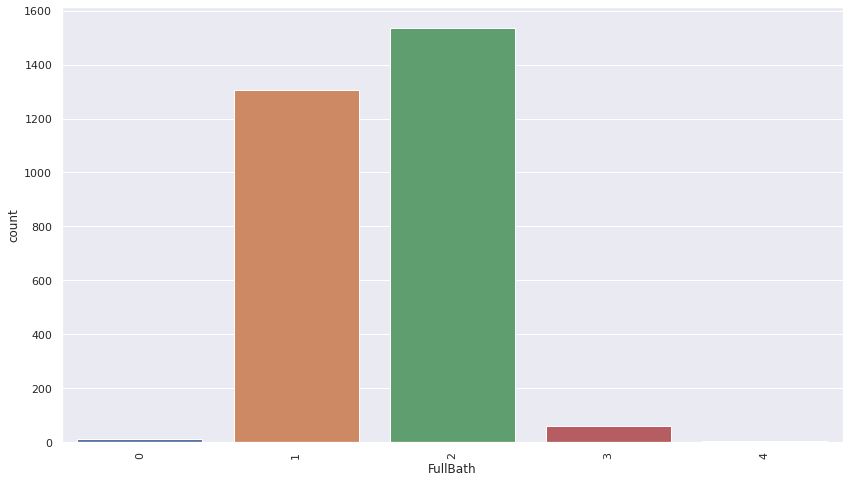

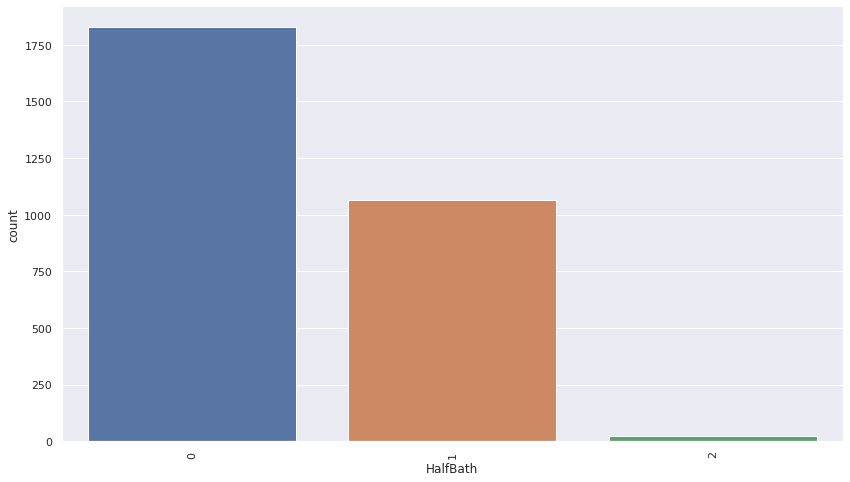

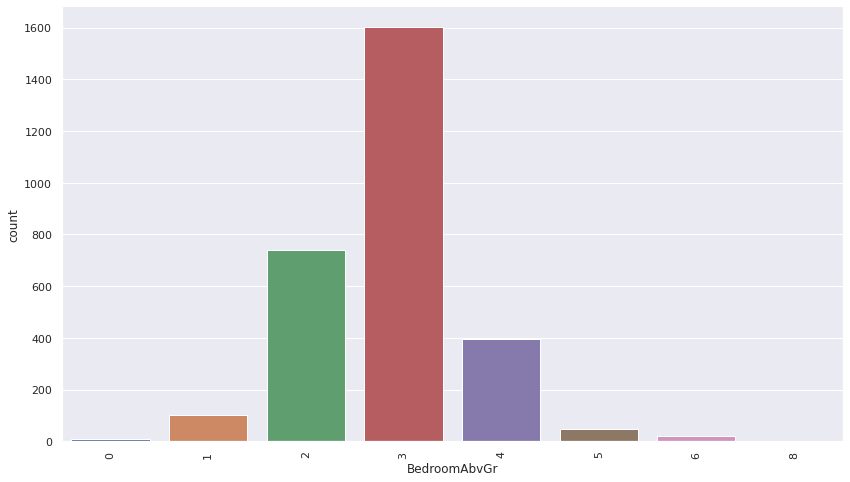

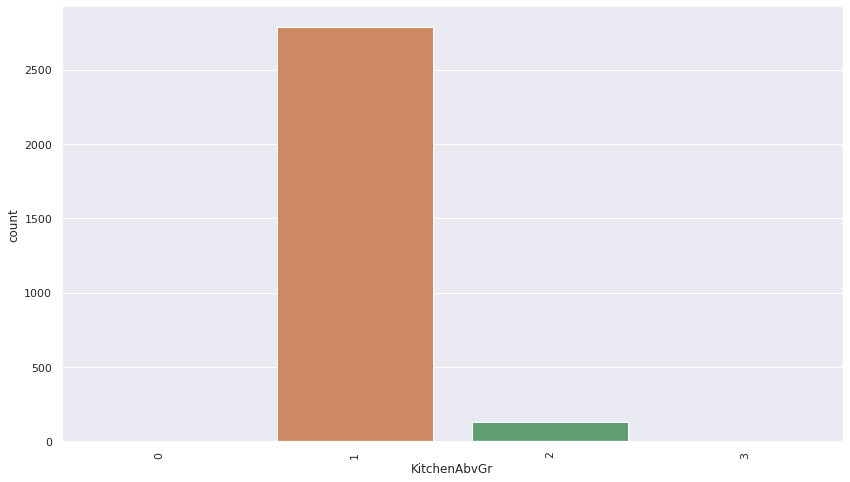

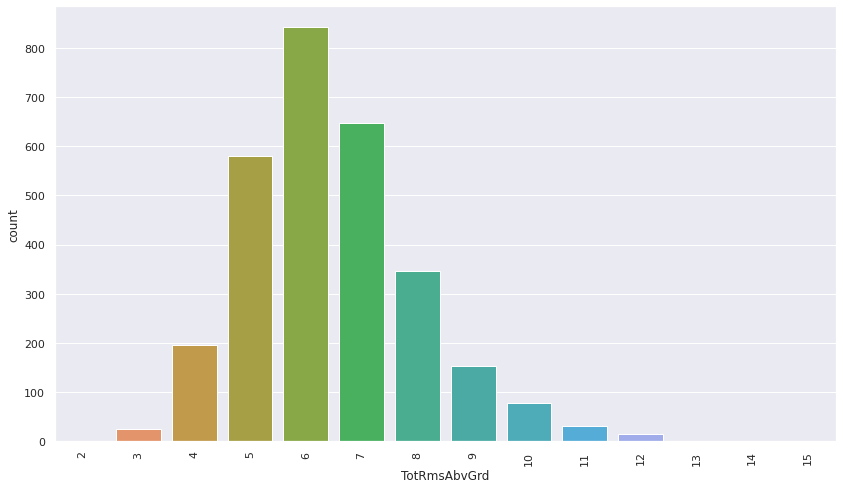

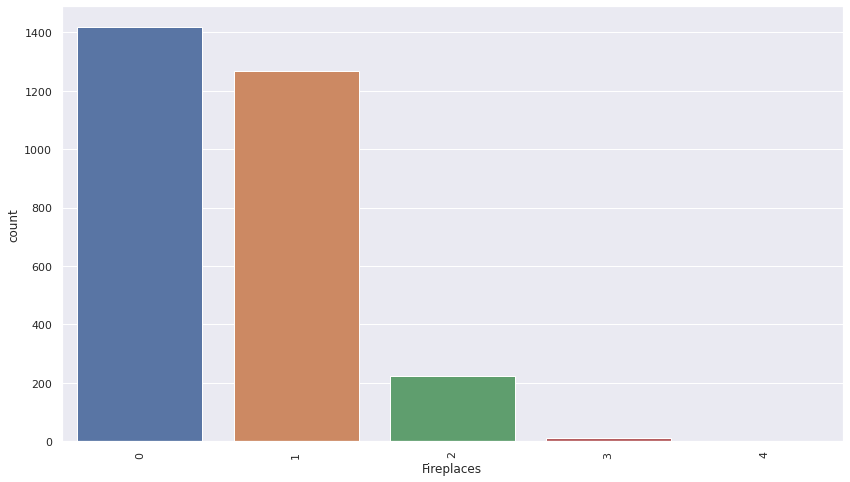

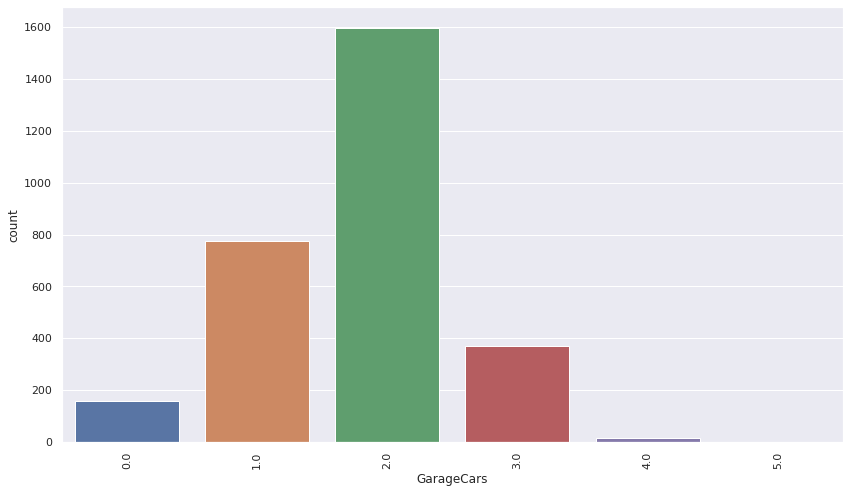

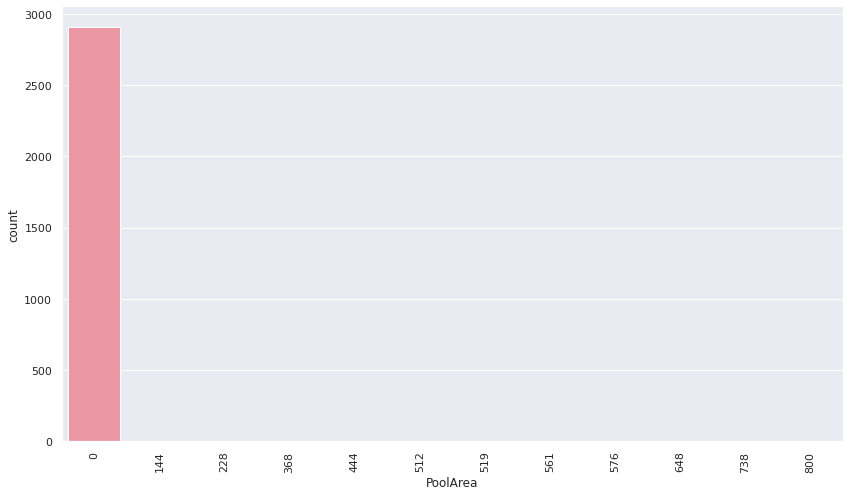

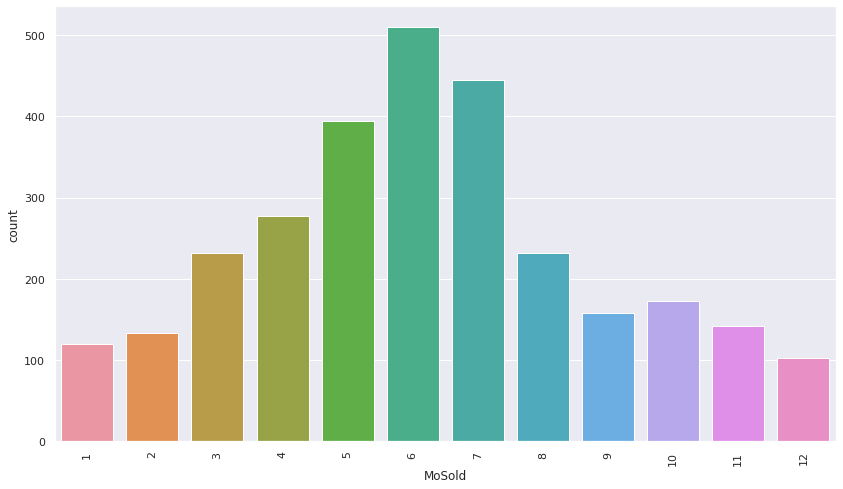

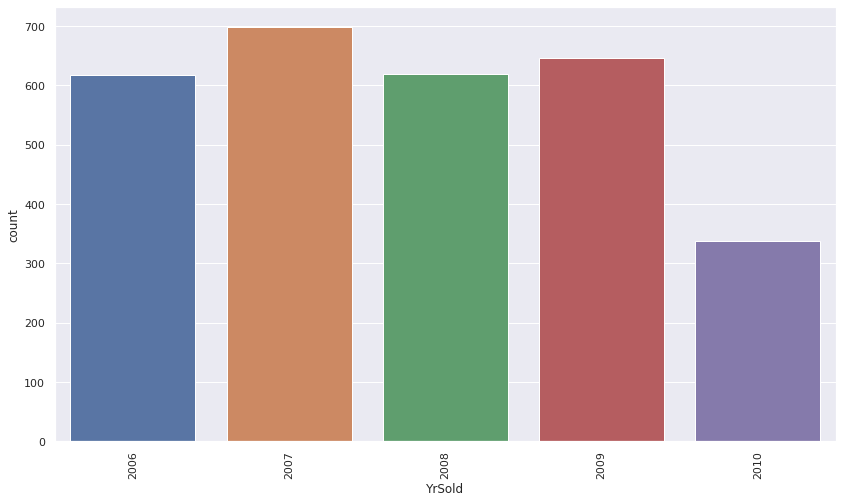

In [50]:
for col in cat_cols:
    plt.figure(figsize=(14, 8))
    sns.countplot(x = data[col], data = data)
    plt.xticks(rotation=90)
    plt.show()

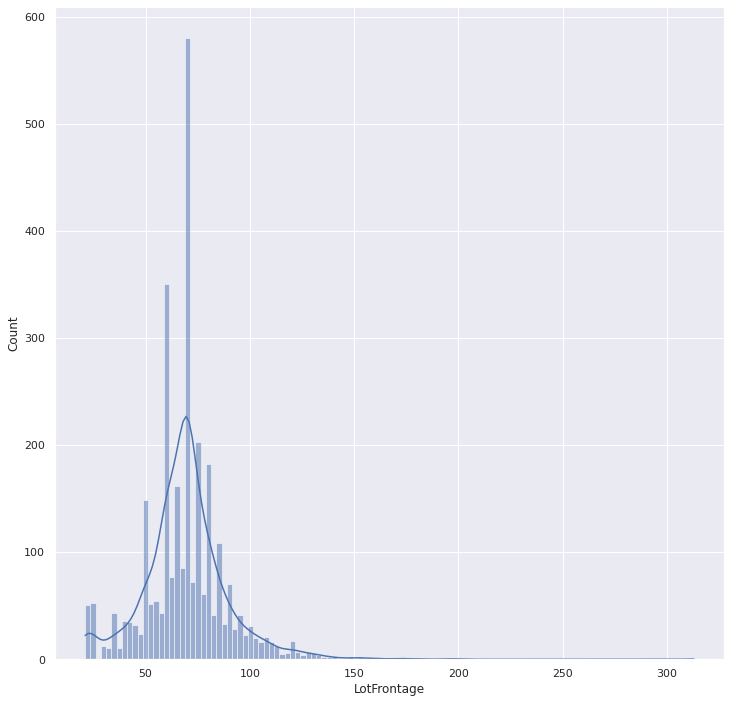

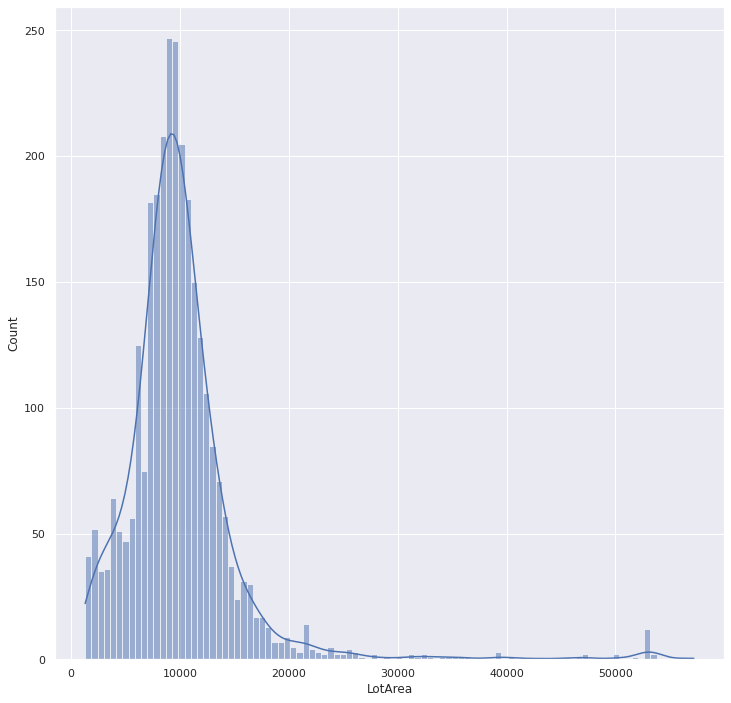

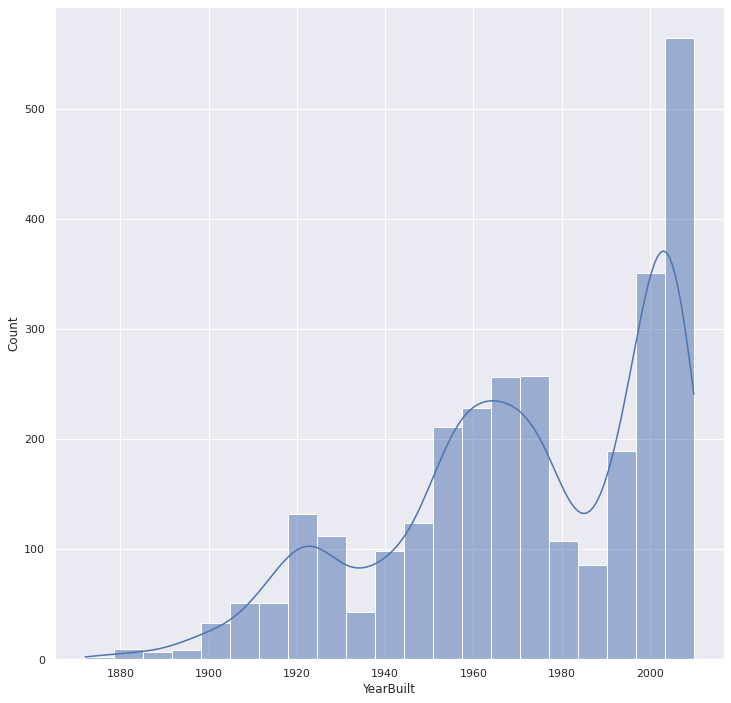

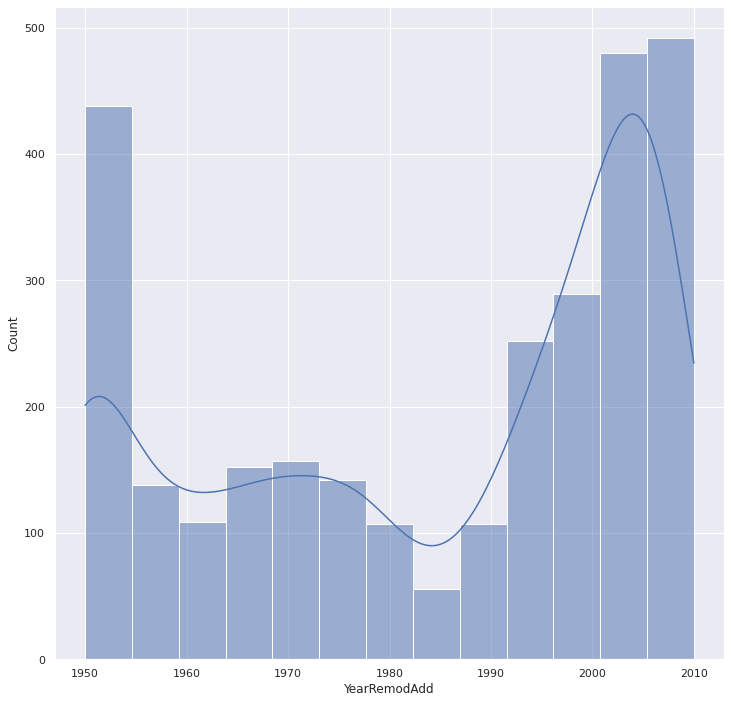

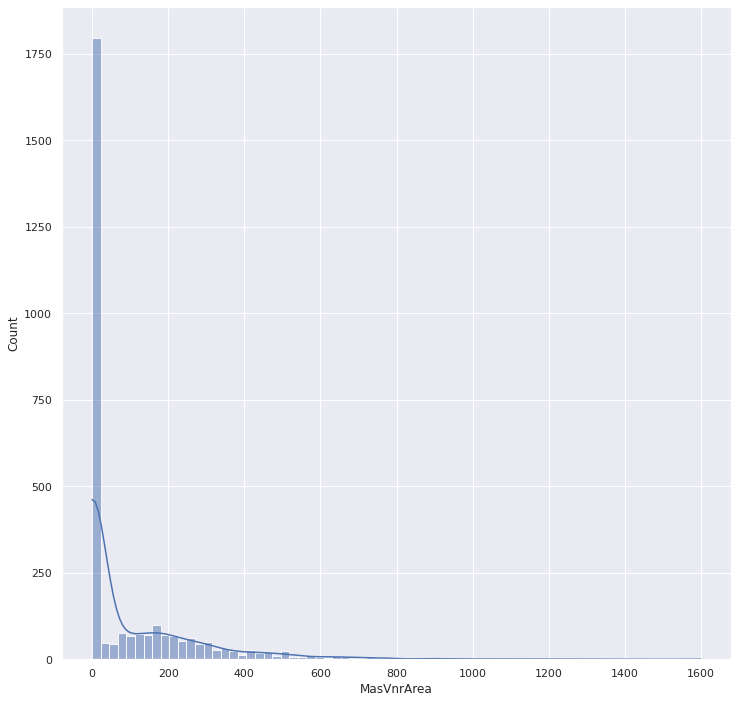

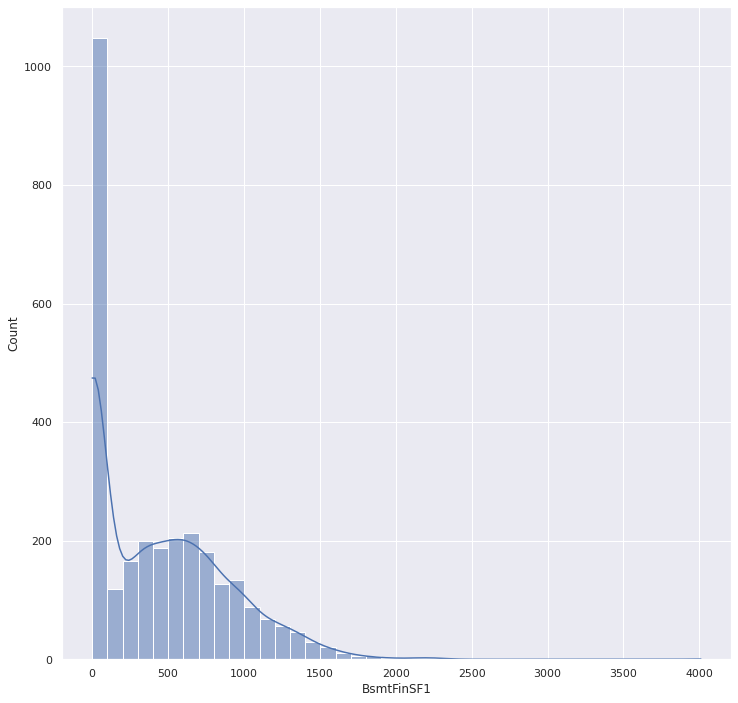

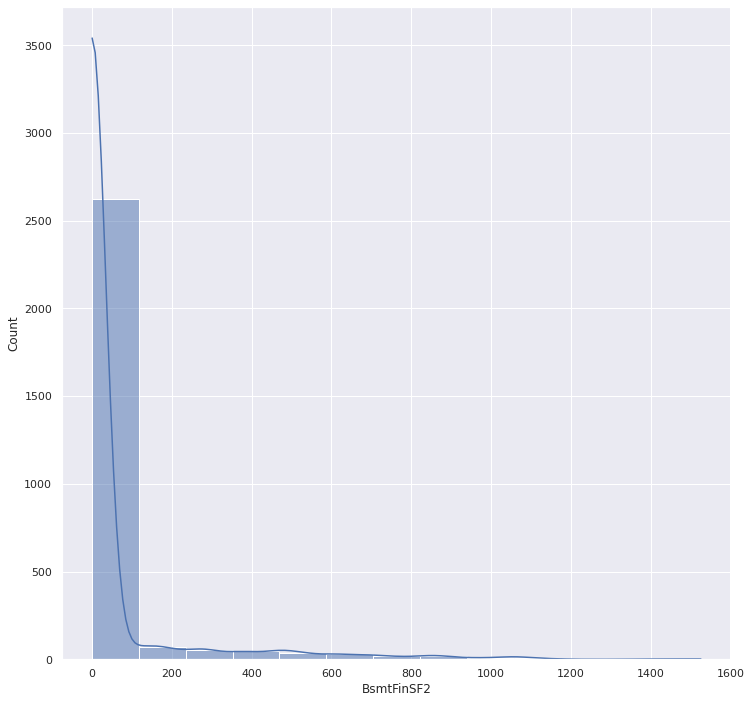

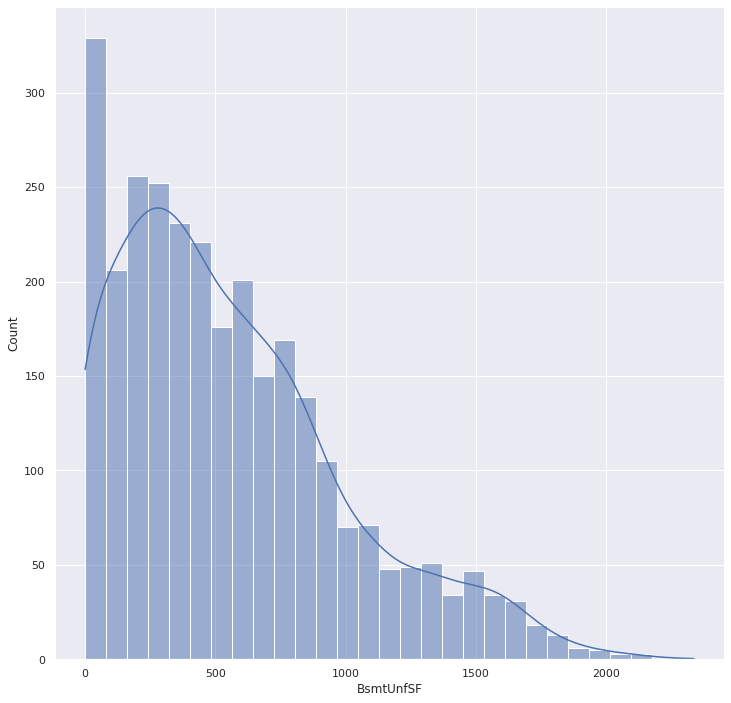

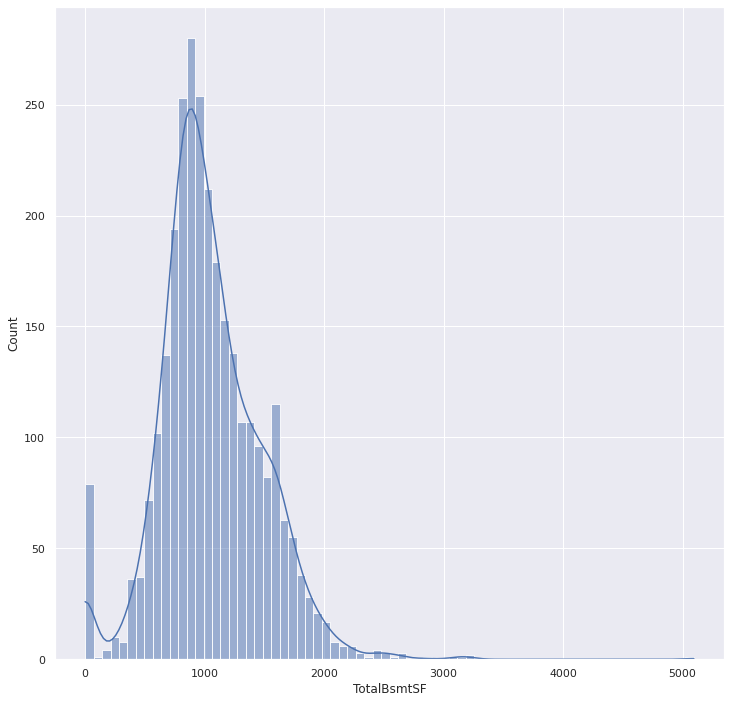

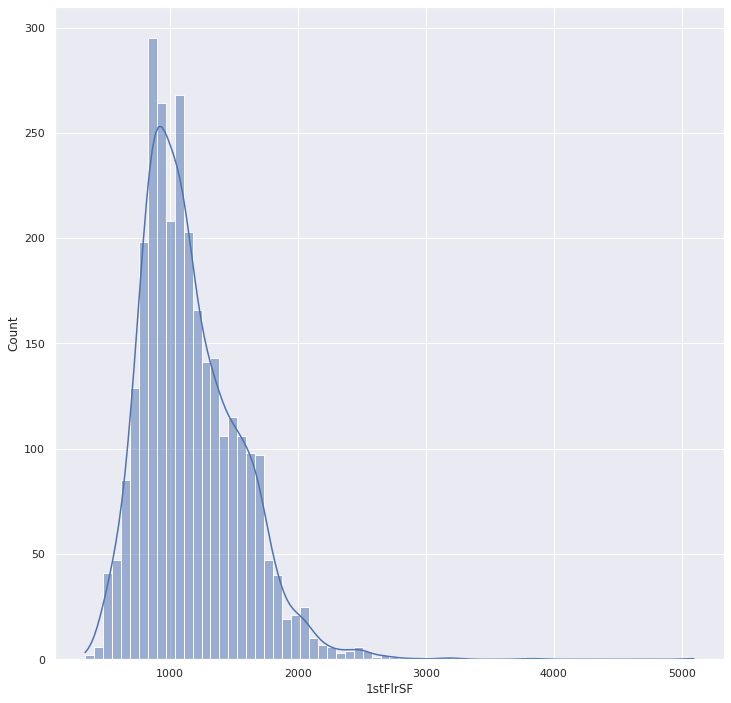

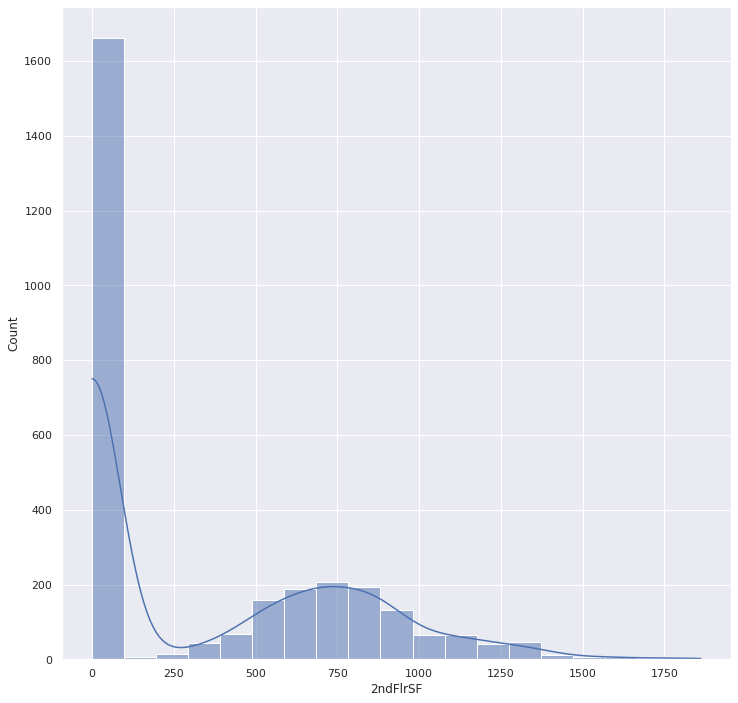

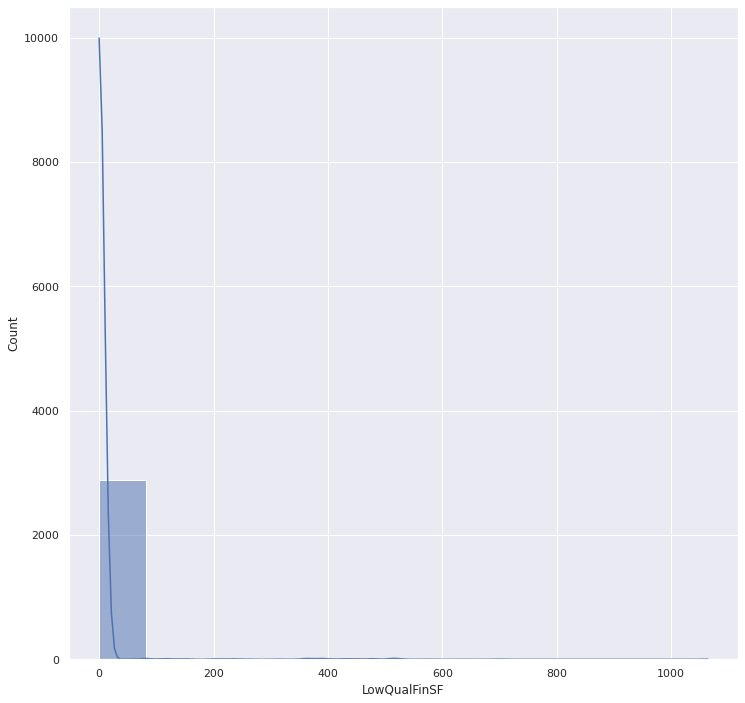

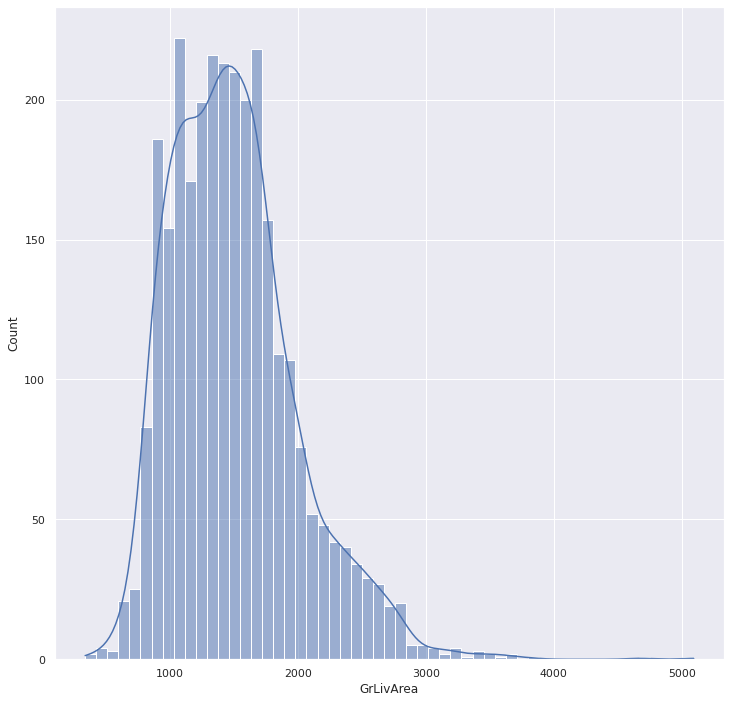

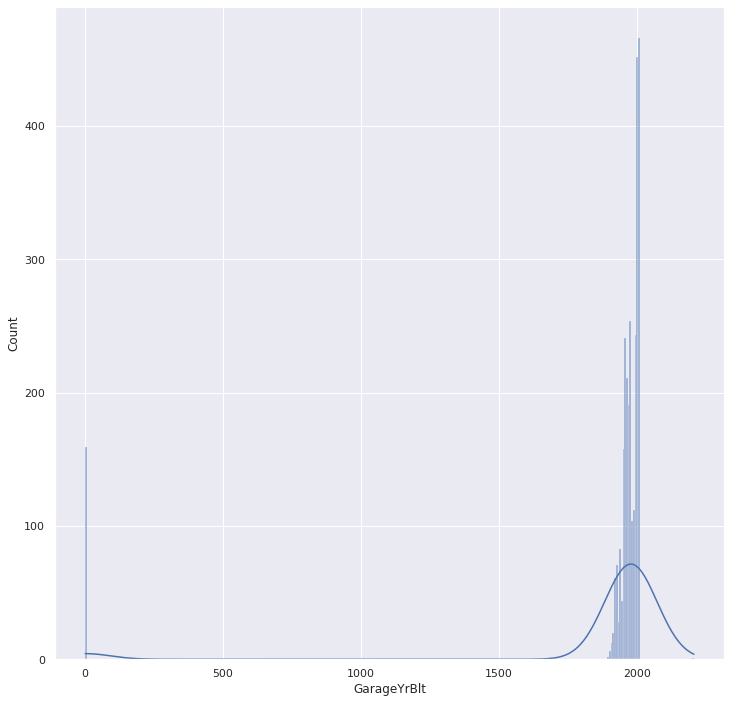

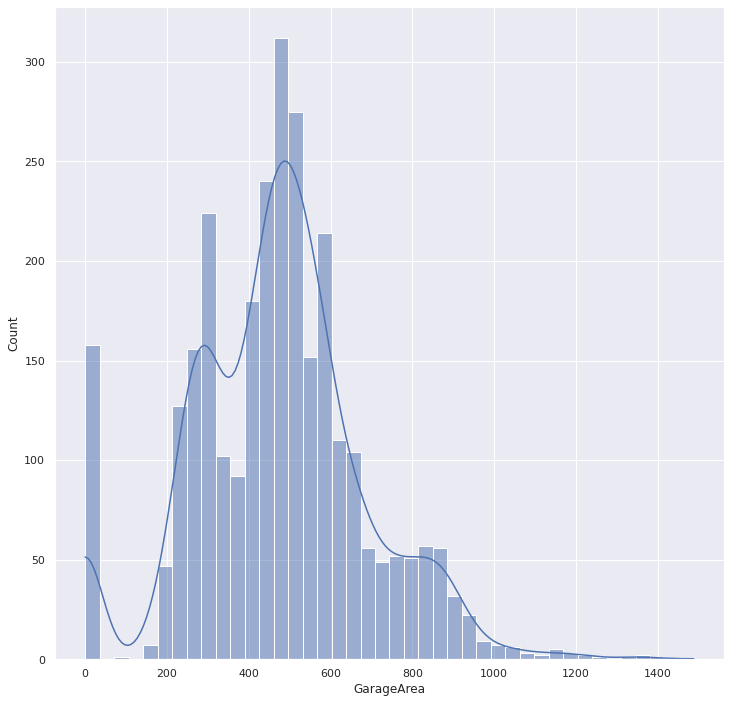

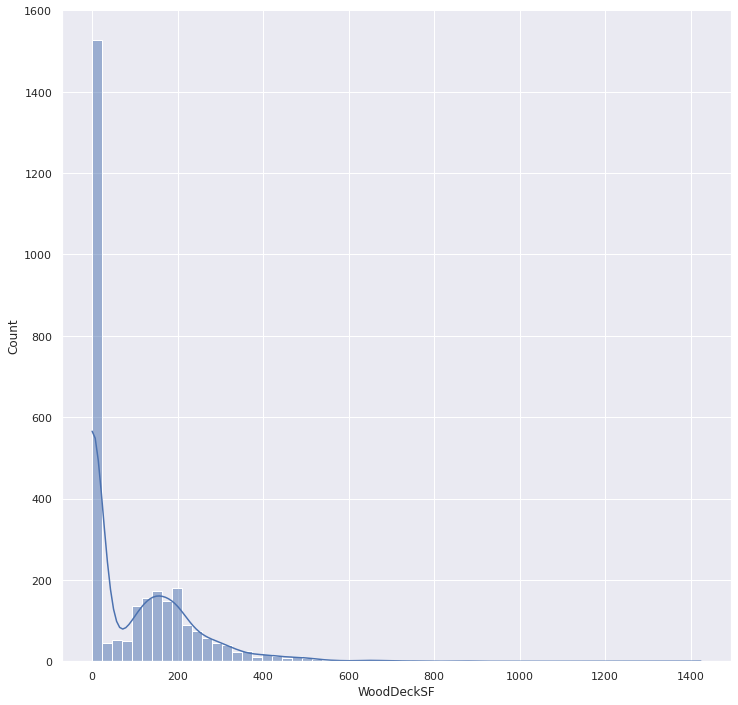

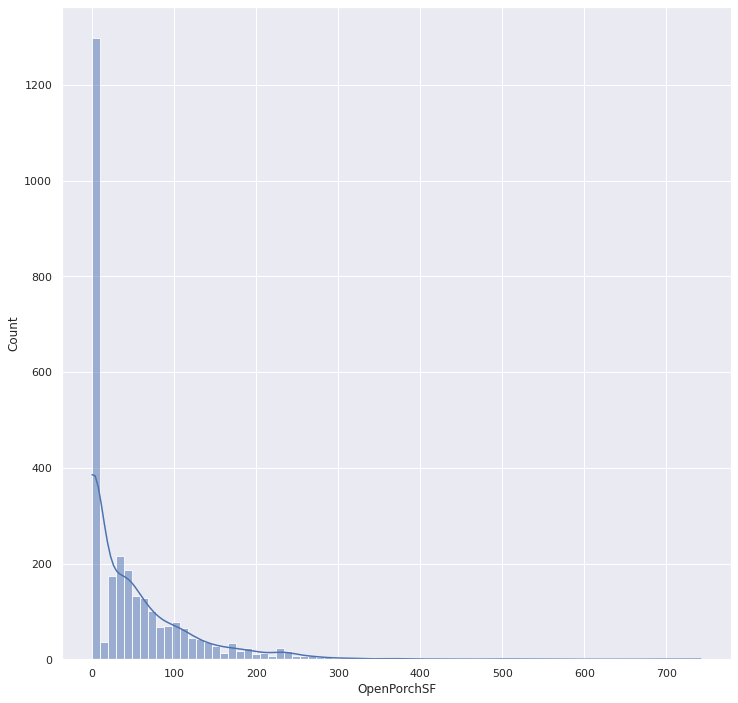

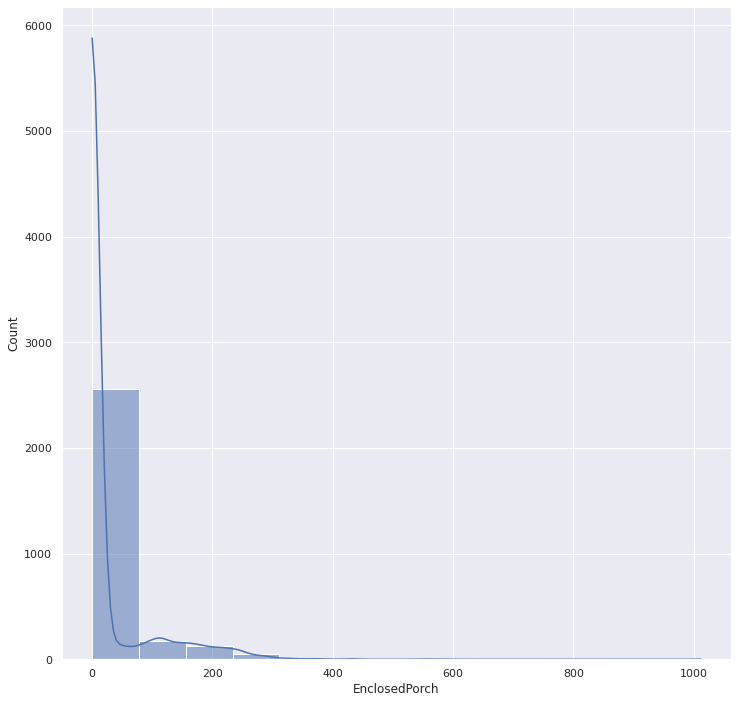

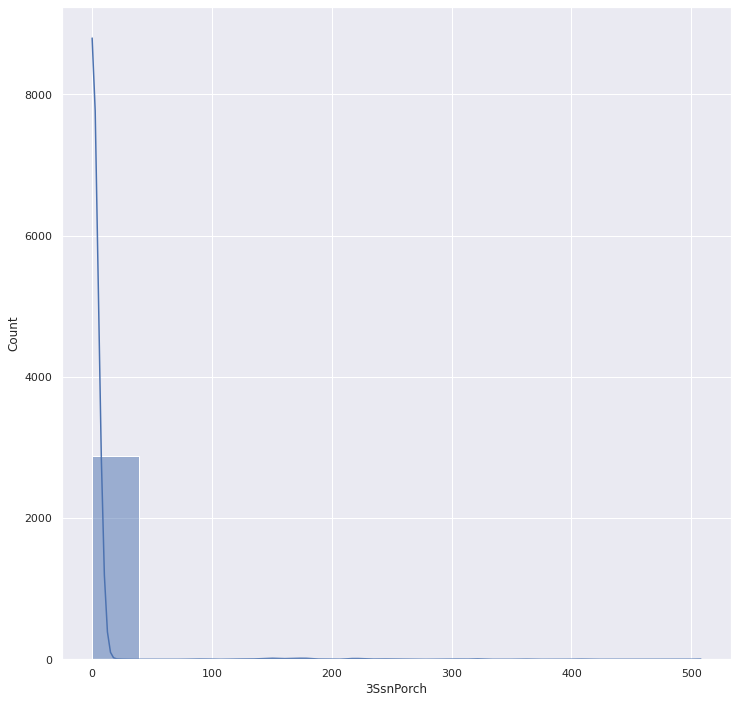

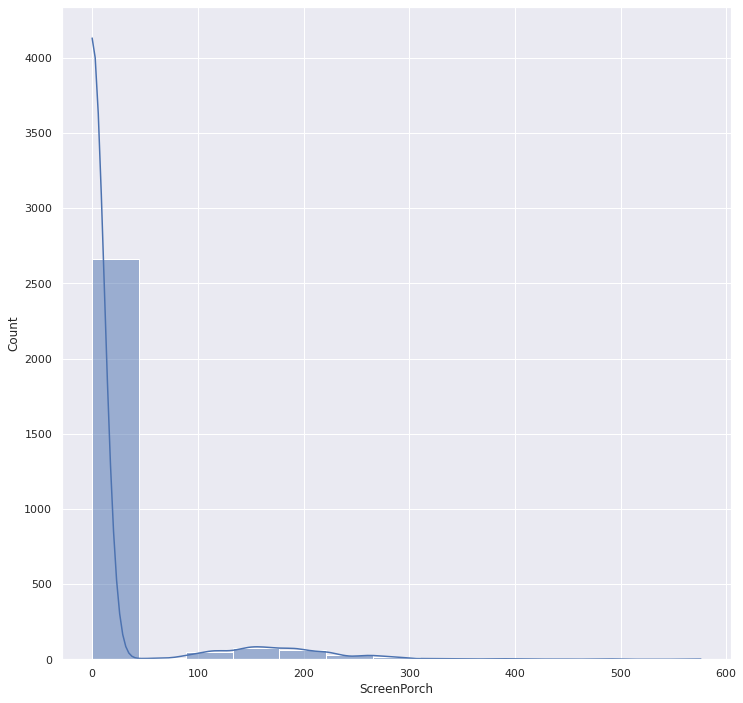

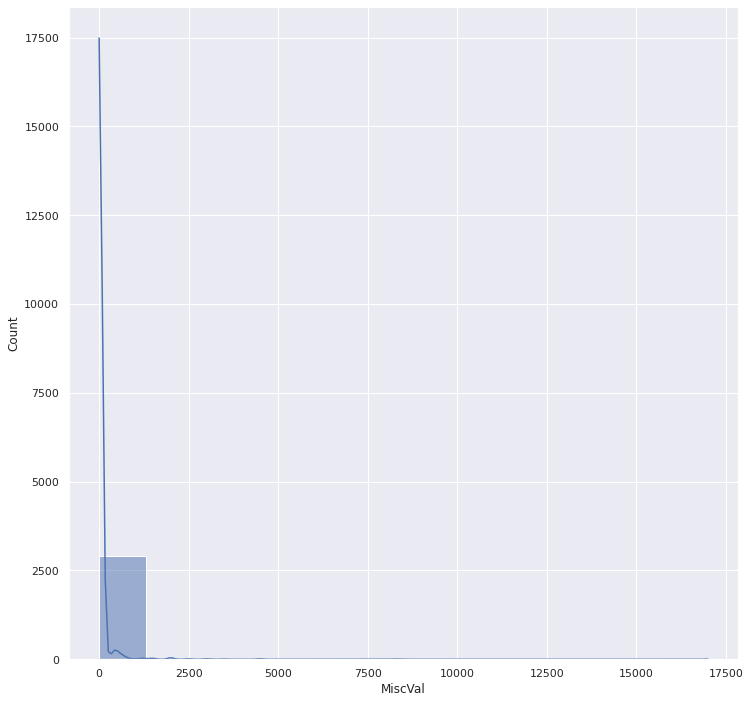

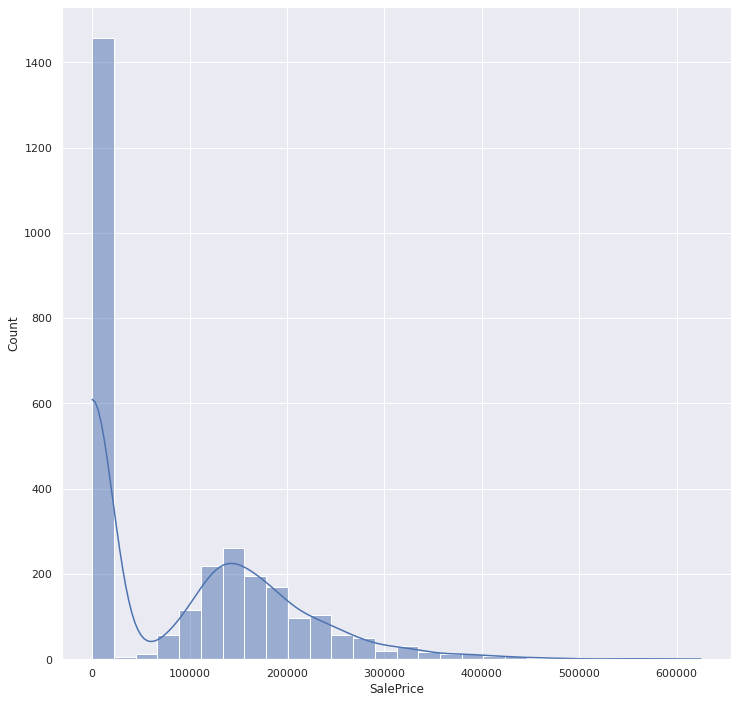

In [51]:
for col in num_cols:
    sns.histplot(x = data[col], data = data, kde = True)
    plt.show()

# **Feature Engineering**

In [52]:
data["PoolArea"].value_counts()

0      2908
512       1
648       1
576       1
519       1
738       1
144       1
368       1
444       1
228       1
561       1
800       1
Name: PoolArea, dtype: int64

*In the "Missing Value" section, we see "PoolArea" has no missing value. So we can see that if value is "0", it's mean there is no pool in the house.*

In [53]:
data["Pool"] = np.where((data["PoolArea"] == 0),0, 1)
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Pool
0,60,RL,65.00,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.00,Gd,TA,PConc,Gd,TA,No,GLQ,706.00,Unf,0.00,150.00,856.00,GasA,Ex,Y,SBrkr,856,854,0,1710,1.00,0.00,2,1,3,1,Gd,8,Typ,0,No,Attchd,2003.00,RFn,2.00,548.00,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500.00,0
1,20,RL,80.00,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.00,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.00,Unf,0.00,284.00,1262.00,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.00,1.00,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.00,RFn,2.00,460.00,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500.00,0
2,60,RL,68.00,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.00,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.00,Unf,0.00,434.00,920.00,GasA,Ex,Y,SBrkr,920,866,0,1786,1.00,0.00,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.00,RFn,2.00,608.00,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500.00,0
3,70,RL,60.00,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.00,TA,TA,BrkTil,TA,Gd,No,ALQ,216.00,Unf,0.00,540.00,756.00,GasA,Gd,Y,SBrkr,961,756,0,1717,1.00,0.00,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.00,Unf,3.00,642.00,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000.00,0
4,60,RL,84.00,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.00,Gd,TA,PConc,Gd,TA,Av,GLQ,655.00,Unf,0.00,490.00,1145.00,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.00,0.00,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.00,RFn,3.00,836.00,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000.00,0


*0: there is no pool
 1: there is a pool*

In [54]:
basement_columns = ["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType2"]

for b in basement_columns:
    print("Col Name:", b)
    print(data[b].value_counts())
    print("#######################################")

Col Name: BsmtQual
TA    1279
Gd    1216
Ex     255
Fa      88
No      81
Name: BsmtQual, dtype: int64
#######################################
Col Name: BsmtCond
TA    2606
Gd     122
Fa     104
No      82
Po       5
Name: BsmtCond, dtype: int64
#######################################
Col Name: BsmtExposure
No    1984
Av     428
Gd     269
Mn     238
Name: BsmtExposure, dtype: int64
#######################################
Col Name: BsmtFinType2
Unf    2495
Rec     104
LwQ      87
No       80
BLQ      67
ALQ      52
GLQ      34
Name: BsmtFinType2, dtype: int64
#######################################


In [55]:
data[["BsmtQual", "BsmtCond", "BsmtFinType2"]].head(20)

,BsmtQual,BsmtCond,BsmtFinType2
0,Gd,TA,Unf
1,Gd,TA,Unf
2,Gd,TA,Unf
3,TA,Gd,Unf
4,Gd,TA,Unf
5,Gd,TA,Unf
6,Ex,TA,Unf
7,Gd,TA,BLQ
8,TA,TA,Unf
9,TA,TA,Unf


In [56]:
data[["BsmtQual", "BsmtCond", "BsmtFinType2"]].tail(20)

,BsmtQual,BsmtCond,BsmtFinType2
2899,TA,TA,Unf
2900,Gd,TA,Unf
2901,Gd,TA,BLQ
2902,Ex,Gd,Unf
2903,Gd,TA,Unf
2904,No,No,No
2905,Gd,TA,Unf
2906,Gd,TA,Unf
2907,TA,TA,Unf
2908,TA,TA,Unf


Even If one of them the columns "BsmtQual", "BsmtCond", or "BsmtFinType2" is "No", that's means "no basement in the house. And it's obvious if one of them is "No", also the others are "No".

In [57]:
data["Basement"] = np.where(((data["BsmtQual"] == "No")&(data["BsmtCond"] == "No")&(data["BsmtFinType2"] == "No")),0, 1)
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Pool,Basement
0,60,RL,65.00,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.00,Gd,TA,PConc,Gd,TA,No,GLQ,706.00,Unf,0.00,150.00,856.00,GasA,Ex,Y,SBrkr,856,854,0,1710,1.00,0.00,2,1,3,1,Gd,8,Typ,0,No,Attchd,2003.00,RFn,2.00,548.00,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500.00,0,1
1,20,RL,80.00,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.00,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.00,Unf,0.00,284.00,1262.00,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.00,1.00,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.00,RFn,2.00,460.00,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500.00,0,1
2,60,RL,68.00,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.00,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.00,Unf,0.00,434.00,920.00,GasA,Ex,Y,SBrkr,920,866,0,1786,1.00,0.00,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.00,RFn,2.00,608.00,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500.00,0,1
3,70,RL,60.00,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.00,TA,TA,BrkTil,TA,Gd,No,ALQ,216.00,Unf,0.00,540.00,756.00,GasA,Gd,Y,SBrkr,961,756,0,1717,1.00,0.00,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.00,Unf,3.00,642.00,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000.00,0,1
4,60,RL,84.00,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.00,Gd,TA,PConc,Gd,TA,Av,GLQ,655.00,Unf,0.00,490.00,1145.00,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.00,0.00,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.00,RFn,3.00,836.00,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000.00,0,1


In [58]:
data[["BsmtQual", "BsmtCond", "BsmtFinType2", "Basement"]].head(20)

,BsmtQual,BsmtCond,BsmtFinType2,Basement
0,Gd,TA,Unf,1
1,Gd,TA,Unf,1
2,Gd,TA,Unf,1
3,TA,Gd,Unf,1
4,Gd,TA,Unf,1
5,Gd,TA,Unf,1
6,Ex,TA,Unf,1
7,Gd,TA,BLQ,1
8,TA,TA,Unf,1
9,TA,TA,Unf,1


*0: there is no basement
 1: there is a basement*

In [59]:
garage_columns = ["GarageType", "GarageFinish", "GarageQual", "GarageCond"]

for g in garage_columns:
    print("Col Name:", g)
    print(data[g].value_counts())
    print("#######################################")

Col Name: GarageType
Attchd     1723
Detchd      779
BuiltIn     186
No          157
Basment      36
2Types       23
CarPort      15
Name: GarageType, dtype: int64
#######################################
Col Name: GarageFinish
Unf    1227
RFn     808
Fin     725
No      159
Name: GarageFinish, dtype: int64
#######################################
Col Name: GarageQual
TA    2604
No     159
Fa     124
Gd      24
Po       5
Ex       3
Name: GarageQual, dtype: int64
#######################################
Col Name: GarageCond
TA    2654
No     159
Fa      74
Gd      15
Po      14
Ex       3
Name: GarageCond, dtype: int64
#######################################


In [60]:
data[["GarageType", "GarageFinish", "GarageQual", "GarageCond"]].tail(20)

,GarageType,GarageFinish,GarageQual,GarageCond
2899,Attchd,Unf,TA,TA
2900,Attchd,Unf,TA,TA
2901,Attchd,Unf,TA,TA
2902,Attchd,Fin,TA,TA
2903,Attchd,Fin,TA,TA
2904,Attchd,Unf,Fa,TA
2905,Attchd,Fin,TA,TA
2906,BuiltIn,RFn,TA,TA
2907,Attchd,RFn,TA,TA
2908,2Types,Unf,TA,TA


The same situation applies here.

In [61]:
data["Garage"] = np.where(((data["GarageType"] == "No")&(data["GarageFinish"] == "No")&(data["GarageQual"] == "No")&(data["GarageCond"] == "No")),0, 1)

In [62]:
data[["GarageType", "GarageFinish", "GarageQual", "GarageCond", "Garage"]].tail(20)

,GarageType,GarageFinish,GarageQual,GarageCond,Garage
2899,Attchd,Unf,TA,TA,1
2900,Attchd,Unf,TA,TA,1
2901,Attchd,Unf,TA,TA,1
2902,Attchd,Fin,TA,TA,1
2903,Attchd,Fin,TA,TA,1
2904,Attchd,Unf,Fa,TA,1
2905,Attchd,Fin,TA,TA,1
2906,BuiltIn,RFn,TA,TA,1
2907,Attchd,RFn,TA,TA,1
2908,2Types,Unf,TA,TA,1


In [63]:
needless_num = ["BsmtUnfSF", "PoolArea", "BsmtFinSF2", "LowQualFinSF", "WoodDeckSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch", "MiscVal"]

In [64]:
needless_cat = ["Utilities", "Condition2", "BsmtFullBath", "BsmtHalfBath", "KitchenAbvGr"]

for col in needless_cat:
    print(data[col].value_counts())
    print("###########################################3")

AllPub    2918
NoSeWa       1
Name: Utilities, dtype: int64
###########################################3
Norm      2889
Feedr       13
Artery       5
PosN         4
PosA         4
RRNn         2
RRAn         1
RRAe         1
Name: Condition2, dtype: int64
###########################################3
0.00    1702
1.00    1180
2.00      35
3.00       2
Name: BsmtFullBath, dtype: int64
###########################################3
0.00    2746
1.00     169
2.00       4
Name: BsmtHalfBath, dtype: int64
###########################################3
1    2785
2     129
0       3
3       2
Name: KitchenAbvGr, dtype: int64
###########################################3


These columns lack variety and do not affect the target (We can see that in the correlation matrix above). So we can drop these columns.

In [65]:
for col in needless_num:
    data.drop(col, axis = 1, inplace = True)

for col in needless_cat:
    data.drop(col, axis = 1, inplace = True)

In [66]:
data.shape

(2919, 65)

In [67]:
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,GrLivArea,FullBath,HalfBath,BedroomAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,OpenPorchSF,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Pool,Basement,Garage
0,60,RL,65.00,8450,Pave,Reg,Lvl,Inside,Gtl,CollgCr,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.00,Gd,TA,PConc,Gd,TA,No,GLQ,706.00,Unf,856.00,GasA,Ex,Y,SBrkr,856,854,1710,2,1,3,Gd,8,Typ,0,No,Attchd,2003.00,RFn,2.00,548.00,TA,TA,Y,61,2,2008,WD,Normal,208500.00,0,1,1
1,20,RL,80.00,9600,Pave,Reg,Lvl,FR2,Gtl,Veenker,Feedr,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.00,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.00,Unf,1262.00,GasA,Ex,Y,SBrkr,1262,0,1262,2,0,3,TA,6,Typ,1,TA,Attchd,1976.00,RFn,2.00,460.00,TA,TA,Y,0,5,2007,WD,Normal,181500.00,0,1,1
2,60,RL,68.00,11250,Pave,IR1,Lvl,Inside,Gtl,CollgCr,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.00,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.00,Unf,920.00,GasA,Ex,Y,SBrkr,920,866,1786,2,1,3,Gd,6,Typ,1,TA,Attchd,2001.00,RFn,2.00,608.00,TA,TA,Y,42,9,2008,WD,Normal,223500.00,0,1,1
3,70,RL,60.00,9550,Pave,IR1,Lvl,Corner,Gtl,Crawfor,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.00,TA,TA,BrkTil,TA,Gd,No,ALQ,216.00,Unf,756.00,GasA,Gd,Y,SBrkr,961,756,1717,1,0,3,Gd,7,Typ,1,Gd,Detchd,1998.00,Unf,3.00,642.00,TA,TA,Y,35,2,2006,WD,Abnorml,140000.00,0,1,1
4,60,RL,84.00,14260,Pave,IR1,Lvl,FR2,Gtl,NoRidge,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.00,Gd,TA,PConc,Gd,TA,Av,GLQ,655.00,Unf,1145.00,GasA,Ex,Y,SBrkr,1145,1053,2198,2,1,4,Gd,9,Typ,1,TA,Attchd,2000.00,RFn,3.00,836.00,TA,TA,Y,84,12,2008,WD,Normal,250000.00,0,1,1


# **Standardization**

*One Hot Encoding*

In [68]:
cat_cols, num_cols, cat_but_car, num_but_cat = categoric_data(data)

Observations: 2919
Variebles: 65
cat_cols: 51
num_cols: 14
cat_but_car: 0
num_but_cat: 14


In [69]:
cat_cols

['MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'SaleType',
 'SaleCondition',
 'MSSubClass',
 'OverallQual',
 'OverallCond',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'MoSold',
 'YrSold',
 'Pool',
 'Basement',
 'Garage']

In [70]:
data = pd.get_dummies(data, columns = cat_cols, drop_first = True)
data.head()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,GarageYrBlt,GarageArea,OpenPorchSF,SalePrice,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Other,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_No,BsmtQual_TA,BsmtCond_Gd,BsmtCond_No,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_No,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_No,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_No,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_No,GarageFinish_No,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_No,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_No,GarageCond_Po,GarageCond_TA,PavedDrive_P,PavedDrive_Y,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,OverallQual_2,OverallQual_3,OverallQual_4,OverallQual_5,OverallQual_6,OverallQual_7,OverallQual_8,OverallQual_9,OverallQual_10,OverallCond_2,OverallCond_3,OverallCond_4,OverallCond_5,OverallCond_6,OverallCond_7,OverallCond_8,OverallCond_9,FullBath_1,FullBath_2,FullBath_3,FullBath_4,HalfBath_1,Half

In [71]:
data.shape

(2919, 300)

*Data Split*

In [72]:
train_df = data.loc[0:1459]
train_df.shape

(1460, 300)

In [73]:
train_df.tail()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,GarageYrBlt,GarageArea,OpenPorchSF,SalePrice,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Other,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_No,BsmtQual_TA,BsmtCond_Gd,BsmtCond_No,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_No,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_No,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_No,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_No,GarageFinish_No,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_No,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_No,GarageCond_Po,GarageCond_TA,PavedDrive_P,PavedDrive_Y,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,OverallQual_2,OverallQual_3,OverallQual_4,OverallQual_5,OverallQual_6,OverallQual_7,OverallQual_8,OverallQual_9,OverallQual_10,OverallCond_2,OverallCond_3,OverallCond_4,OverallCond_5,OverallCond_6,OverallCond_7,OverallCond_8,OverallCond_9,FullBath_1,FullBath_2,FullBath_3,FullBath_4,HalfBath_1,Half

In [74]:
test_df = data.loc[1460:]
test_df.shape

(1459, 300)

In [75]:
test_df = test_df.reset_index(drop = True)
test_df.head()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,GarageYrBlt,GarageArea,OpenPorchSF,SalePrice,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Other,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_No,BsmtQual_TA,BsmtCond_Gd,BsmtCond_No,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_No,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_No,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_No,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_No,GarageFinish_No,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_No,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_No,GarageCond_Po,GarageCond_TA,PavedDrive_P,PavedDrive_Y,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,OverallQual_2,OverallQual_3,OverallQual_4,OverallQual_5,OverallQual_6,OverallQual_7,OverallQual_8,OverallQual_9,OverallQual_10,OverallCond_2,OverallCond_3,OverallCond_4,OverallCond_5,OverallCond_6,OverallCond_7,OverallCond_8,OverallCond_9,FullBath_1,FullBath_2,FullBath_3,FullBath_4,HalfBath_1,Half

# Modelling

In [76]:
y_train = train_df["SalePrice"]
x_train = train_df.drop(["SalePrice"], axis = 1)
x_test = test_df.drop(["SalePrice"], axis = 1)

***Multiple Linear Regression***

In [77]:
mlr_model = LinearRegression()
mlr_model.fit(x_train, y_train)
y_predict = mlr_model.predict(x_test)

In [78]:
mlr_model.score(x_train, y_train)

0.9286467577100276

In [79]:
cross_val_score(mlr_model, x_train, y_train, cv = 10, scoring = "r2").mean()

0.8684193345427879

***Ligth GBM Regressor***

In [80]:
lgbm_model = LGBMRegressor()
lgbm_model.fit(x_train, y_train)
y_pred_lgbm = lgbm_model.predict(x_test)

In [81]:
lgbm_model.score(x_train, y_train)

0.9837071330012188

In [82]:
cross_val_score(lgbm_model, x_train, y_train, cv = 10, scoring = "r2").mean()

0.8829612519467384

# Submission

In [83]:
sample['SalePrice'] = y_pred_lgbm
sample.to_csv('predictions.csv', index=False)

In [84]:
output = pd.read_csv("/kaggle/working/predictions.csv")
output.head()

,Id,SalePrice
0,1461,119325.91
1,1462,240815.33
2,1463,192625.92
3,1464,196440.67
4,1465,192640.02
